### TO DO:

- All of the text can be edited and rewritten
- Add links/citations
- Check on the empirical targets, both in the CSTW paper/code/repo and recent measurements from the literature


# The Distribution of Wealth and the MPC

This notebook presents an analogous selection of results from the paper [The Distribution of Wealth and the Marginal Propensity to Consume](http://econ.jhu.edu/people/ccarroll/papers/cstwMPC), using the [Econ-ARK/HARK](https://github.com/econ-ark/HARK) toolkit. In this version of the model, the results are presented for the estimation procedure with the **rate of return** as the key parameter of interest. 

In [1]:
# This cell does some standard python setup!

import code.calibration as parameters
import warnings  # The warnings package allows us to ignore some harmless but alarming warning messages
from code.calibration import SCF_wealth, SCF_weights
from code.estimation import estimate

# Import related generic python packages
import matplotlib.pyplot as plt  # Plotting tools
import numpy as np
from HARK.utilities import get_lorenz_shares

warnings.filterwarnings("ignore")


def mystr(number):
    return f"{number:.4f}"

## Contributions from the CSTW paper

### Heterogeneous Time Preferences

In a model calibrated to match micro- and macroeconomic evidence on household income dynamics, (cite the CSTW paper) shows that a modest degree of heterogeneity in household preferences or beliefs is sufficient to match empirical measures of wealth inequality in the U.S. 

In cstwMPC, the authors calibrated nearly all of the model parameters-- risk aversion, income shock process, etc-- to commonly used or previously estimated values.  The only parameter to be estimated is the distribution of $\beta$.  cstwMPC assumed that $\beta$ is uniformly distributed on $[\grave{\beta}-\nabla,\grave{\beta}+\nabla]$, approximated by a seven point distribution.

### Empirical Wealth Targets

Their estimation procedure seeks the values of $\grave{\beta}$ and $\nabla$ that generate a simulated distribution of wealth that best matches empirical U.S. data.  Their definition of "best match" has two aspects:

1. The simulated aggregate capital-to-income ratio matches the true U.S. value.
2. The sum of squared distances between the simulated and empirical Lorenz curves (at the 20th, 40th, 60th, and 80th percentiles) is minimized (conditional on item 1).

cstwMPC's target empirical moments are a capital-to-income ratio of 10.26 and cumulative wealth shares as given in the table below.  Yes, you are reading the table correctly: The "poorest" 80 percent of households own 17.5 percent of wealth.

| Net worth percentile | Cumulative wealth share |
|:---:|:---:|
|  20th  | -0.2% |
|  40th  | 1.0% |
|  60th  | 5.5% |
|  80th  | 17.5% |

For a description of the relevant notation and the optimization problem that households solve, see (Link to the CSTW notebook). Importantly, the estimation procedure in this paper will use the same empirical targets as those presented there.

## Heterogeneous Rates of Return

### Theoretical Motivation 

As discussed in the DemARK (link to Micro-and-Macro-Implications...), Buffer stock saving models of the kind implemented in $\texttt{ConsIndShockType}$ say that, if a standard ['Growth Impatience Condition'](https://econ-ark.github.io/BufferStockTheory/#GICRaw), holds:

\begin{eqnarray}
\newcommand{\Rfree}{\mathsf{R}}\newcommand{\DiscFac}{\beta}\newcommand{\PermGroFac}{\Gamma}\newcommand{\PermShk}{\psi}\newcommand{\CRRA}{\rho}
\left(\frac{(\Rfree\DiscFac)^{1/\CRRA}\mathbb{E}[\PermShk^{-1}]}{\PermGroFac}\right) & < & 1
\end{eqnarray}

then the _ratio_ of asets $\newcommand{\aLev}{\mathbf{a}}\aLev$ to permanent income $\newcommand{\pLev}{\mathbf{p}}\pLev$, $a=\aLev/\pLev$, has a target value $\newcommand{\aTarg}{\check{a}}\aTarg$ that depends on the consumer's preferences (relative risk aversion $\CRRA$, time preference $\DiscFac$) and circumstances (interest factor $\Rfree$, growth factor $\PermGroFac$, uncertainty about permanent income shocks $\sigma^{2}_{\PermShk}$).

If everyone had identical preferences and everyone were at their target $\check{a}$, then inequality in the level of $\aLev$ would be exactly the same as inequality in $\pLev$. 

Moreover, since each of the parameters featured in this Growth Impatience Condition capture aspects of the household's optimal consumption-savings behavior, the assumption that households differ significantly in the value of one or many of these variables can potentially explain disparities in wealth accumulation over the life-cycle.

### Empirical Evidence 

It is worth noting that the time preference factor $(\beta)$ is one of the key parameters that influences an individual's equilibrium target level of market resources, but it is not directly observable. Therefore, in order to estimate $\beta$, one would need to gather data through surveys or other methods that allow for the direct acquisition of information from households.

On the other hand, estimating differences in the rate of return $(\Rfree)$ to financial assets across households is possible, as this variable *is* directly observable. Recent empirical recent has exploited the usefulness novel, administrative and survey datasets on household asset holdings in an attempt to quantify the differences in returns among individuals. These datasets are "novel" in the sense that they are more representative of household finances than their U.S. counterparts, which are known to suffer from substantial measurement bias, especially at the top end of the wealth distribution. 

Among these recent empirical efforts are the following notable contributions (provide actual citation/links for each of these):

1. Do the Rich Get Richer in the Stock Market? Evidence from India
2. Financial Literacy and Savings Account Returns
3. Rich Pickings? Risk, Return, and Skill in Household Wealth
4. Heterogeneity and Persistence in Returns to Wealth

Not only do each of these papers provide motivation for the estimation of a buffer-stock savings model with ex-ante heterogeneity in the rate of return, but they also offer a baseline for evaluating the results of the procedure. That is, the distribution of rates of return which are produced in this notebook should be "close" to the empirical estimates presented in these papers.

*In this notebook, the notion of "closeness" will be a graphical comparison. However, it is clear that a more mathematical description can be presented (much as the distance between the simulated and empirical Lorenz points are minimized).* (-revise this, could be said much better!)

## Goals of this Notebook

* Run the simplest specification of the estimation for Rfree
* Compare the results to CSTW... how "close" are the Lorenz sim points to the empirical counterpart?
* Compare the estimated distribution of Rfree to the "empirical counterpart" regarding heterogeneous returns, from the four empirical papers listed above

In [2]:
"""
This will run the absolute minimum amount of work that actually produces
relevant output-- no aggregate shocks, perpetual youth, matching net worth.
Will run both beta-point and beta-dist versions.
"""

"""
Copied here from do_min.py.
Design decisions about whether to include this code explicitly,
or import it, or execute it as is here, TBD.
"""

'\nCopied here from do_min.py.\nDesign decisions about whether to include this code explicitly,\nor import it, or execute it as is here, TBD.\n'

In [3]:
# For speed here, use the "tractable" version of the model
# This is not the "right" model, but illustrates the key point
"""
This options file specifies parameter heterogeneity, making the choice in the paper:
uniformly distributed discount factors.
"""
param_name = "Rfree"  # Which parameter to introduce heterogeneity in
dist_type = "uniform"  # Which type of distribution to use

"""
This options file specifies the "standard" work options for cstwMPC, estimating the model only.
"""
run_estimation = True  # Runs the estimation if True
# Choose which sensitivity analyses to run: rho, xi_sigma, psi_sigma, mu, urate, mortality, g, R
run_sensitivity = [False, False, False, False, False, False, False, False]
# Computes K/Y ratio for a wide range of beta; should have do_beta_dist = False
find_beta_vs_KY = False
# Uses a "tractable consumer" rather than solving full model when True
do_tractable = True

# Solve for the $\beta-Point$ (do_param_dist=False) for speed
"""
This options file establishes the second simplest model specification possible:
with heterogeneity, no aggregate shocks, perpetual youth model, matching net worth.
"""

do_param_dist = False  # Do param-dist version if True, param-point if False
do_lifecycle = False  # Use lifecycle model if True, perpetual youth if False
do_agg_shocks = False  # Solve the FBS aggregate shocks version of the model
# Matches liquid assets data when True, net worth data when False
do_liquid = False

GPFRaw                 = 0.976162 
GPFNrm                 = 0.979350 
GPFAggLivPrb           = 0.970061 
Thorn = APF            = 0.976162 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.990453 
DiscFacGPFAggLivPrbMax = 0.999938 


Beginning an estimation with the specification name PYrratePointIndNetWorth...
1.0063522012578616


GPFRaw                 = 1.082862 
GPFNrm                 = 1.086399 
GPFAggLivPrb           = 1.076094 
Thorn = APF            = 1.082862 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.892858 
DiscFacGPFAggLivPrbMax = 0.901408 


get_KY_ratio_difference tried center = 1.0063522012578616 and got -9.6345541430904
1.1163522012578617


GPFRaw                 = 0.976162 
GPFNrm                 = 0.979350 
GPFAggLivPrb           = 0.970061 
Thorn = APF            = 0.976162 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.990453 
DiscFacGPFAggLivPrbMax = 0.999938 


get_KY_ratio_difference tried center = 1.1163522012578617 and got 395459849006.90906
1.0063522012605415


GPFRaw                 = 1.002837 
GPFNrm                 = 1.006112 
GPFAggLivPrb           = 0.996569 
Thorn = APF            = 1.002837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.964107 
DiscFacGPFAggLivPrbMax = 0.973340 


get_KY_ratio_difference tried center = 1.0063522012605415 and got -9.634554143057901
1.0338522964283747


GPFRaw                 = 1.002837 
GPFNrm                 = 1.006112 
GPFAggLivPrb           = 0.996569 
Thorn = APF            = 1.002837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.964107 
DiscFacGPFAggLivPrbMax = 0.973340 


get_KY_ratio_difference tried center = 1.0338522964283747 and got -7.409844495501105
1.0338522964314665


GPFRaw                 = 1.042849 
GPFNrm                 = 1.046256 
GPFAggLivPrb           = 1.036331 
Thorn = APF            = 1.042849 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.927116 
DiscFacGPFAggLivPrbMax = 0.935994 


get_KY_ratio_difference tried center = 1.0338522964314665 and got -7.409844493169697
1.0751022488446642


GPFRaw                 = 1.012368 
GPFNrm                 = 1.015675 
GPFAggLivPrb           = 1.006041 
Thorn = APF            = 1.012368 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.955030 
DiscFacGPFAggLivPrbMax = 0.964176 


get_KY_ratio_difference tried center = 1.0751022488446642 and got 400052.8790925666
1.0436785041428347


GPFRaw                 = 1.006193 
GPFNrm                 = 1.009479 
GPFAggLivPrb           = 0.999904 
Thorn = APF            = 1.006193 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.960892 
DiscFacGPFAggLivPrbMax = 0.970093 


get_KY_ratio_difference tried center = 1.0436785041428347 and got 34.681553881907305
1.0373119425306532


GPFRaw                 = 1.006997 
GPFNrm                 = 1.010286 
GPFAggLivPrb           = 1.000703 
Thorn = APF            = 1.006997 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.960124 
DiscFacGPFAggLivPrbMax = 0.969319 


get_KY_ratio_difference tried center = 1.0373119425306532 and got -1.591402273515488
1.0381407730652257


GPFRaw                 = 1.006595 
GPFNrm                 = 1.009883 
GPFAggLivPrb           = 1.000303 
Thorn = APF            = 1.006595 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.960508 
DiscFacGPFAggLivPrbMax = 0.969706 


get_KY_ratio_difference tried center = 1.0381407730652257 and got 0.8648052602027949
1.0377263577979394


GPFRaw                 = 1.006730 
GPFNrm                 = 1.010018 
GPFAggLivPrb           = 1.000437 
Thorn = APF            = 1.006730 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.960379 
DiscFacGPFAggLivPrbMax = 0.969576 


get_KY_ratio_difference tried center = 1.0377263577979394 and got -0.41731496892270314
1.037865495265322


GPFRaw                 = 1.006729 
GPFNrm                 = 1.010017 
GPFAggLivPrb           = 1.000437 
Thorn = APF            = 1.006729 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.960380 
DiscFacGPFAggLivPrbMax = 0.969576 


get_KY_ratio_difference tried center = 1.037865495265322 and got 0.0008749449132050557
1.0378649130531963


GPFRaw                 = 1.006729 
GPFNrm                 = 1.010018 
GPFAggLivPrb           = 1.000437 
Thorn = APF            = 1.006729 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.960379 
DiscFacGPFAggLivPrbMax = 0.969576 


get_KY_ratio_difference tried center = 1.0378649130531963 and got -0.000962285411659991
1.037865204159259
Estimate is center=1.037865204159259, spread=0.0, took 34.73388385772705 seconds.
Running in interactive shell (Jupyter notebook or spyder)


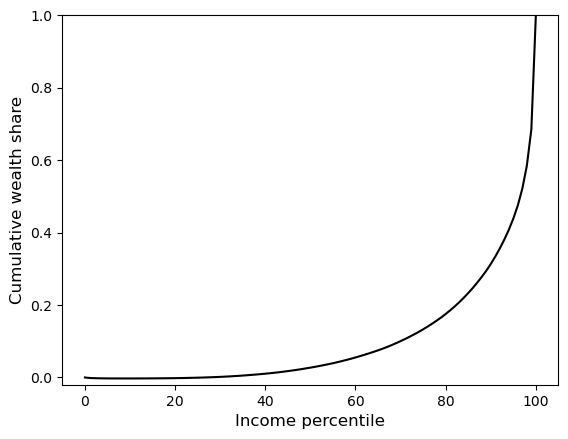

Estimate is center=1.037865204159259, spread=0.0
Lorenz distance is 39.8217250255979
Average MPC for all consumers is 0.168
Average MPC in the top percentile of W/Y is 0.137
Average MPC in the top decile of W/Y is 0.139
Average MPC in the top quintile of W/Y is 0.139
Average MPC in the second quintile of W/Y is 0.141
Average MPC in the middle quintile of W/Y is 0.142
Average MPC in the fourth quintile of W/Y is 0.145
Average MPC in the bottom quintile of W/Y is 0.272
Average MPC in the top percentile of y is 0.143
Average MPC in the top decile of y is 0.146
Average MPC in the top quintile of y is 0.153
Average MPC in the second quintile of y is 0.186
Average MPC in the middle quintile of y is 0.188
Average MPC in the fourth quintile of y is 0.151
Average MPC in the bottom quintile of y is 0.161
Average MPC for the employed is 0.165
Average MPC for the unemployed is 0.200
Average MPC for the retired is nan
Of the population with the 1/3 highest MPCs...
69.689% are in the bottom wealth q

In [4]:
options = {
    "param_name": param_name,
    "dist_type": dist_type,
    "run_estimation": run_estimation,
    "run_sensitivity": run_sensitivity,
    "find_beta_vs_KY": find_beta_vs_KY,
    "do_tractable": do_tractable,
    "do_param_dist": do_param_dist,
    "do_lifecycle": do_lifecycle,
    "do_agg_shocks": do_agg_shocks,
    "do_liquid": do_liquid,
}


EstimationEconomy = estimate(options, parameters)

[28166.70970403   776.94602603  5248.56550008 ...  4733.3783942
  2194.69496871   375.79007154]
[array([28166.70970403,   776.94602603,  5248.56550008, ...,
        4733.3783942 ,  2194.69496871,   375.79007154]), array([15092.91908501,  1875.04938636,  4858.94843931, ...,
       15744.39265101,   363.80861269,  2176.50316651]), array([  816.2641941 , 11054.45010509,   381.2821817 , ...,
        4965.66913649,  5322.36622486, 16351.67599128])]


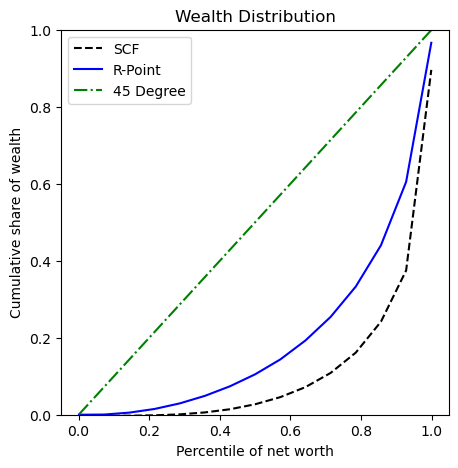

In [28]:
# Construct the Lorenz curves and plot them

pctiles = np.linspace(0.001, 0.999, 15)
SCF_Lorenz_points = get_lorenz_shares(
    SCF_wealth, weights=SCF_weights, percentiles=pctiles
)

sim_wealth = EstimationEconomy.reap_state["aLvl"][0]
sim_Lorenz_points = get_lorenz_shares(sim_wealth, percentiles=pctiles)

# Plot
plt.figure(figsize=(5, 5))
plt.title("Wealth Distribution")
plt.plot(pctiles, SCF_Lorenz_points, "--k", label="SCF")
plt.plot(pctiles, sim_Lorenz_points, "-b", label="R-Point")
plt.plot(pctiles, pctiles, "g-.", label="45 Degree")
plt.xlabel("Percentile of net worth")
plt.ylabel("Cumulative share of wealth")
plt.legend(loc=2)
plt.ylim([0, 1])
plt.show("wealth_distribution_1")

## Return Preference Heterogeneneity

The analog to the CSTW (link to paper/notebook) work is referred to as the $\Rfree$-Dist model. Here, households no longer have the same rate of return to their assets. Instead, the model assumes that, for some dispersion $\nabla$, the rate of return to assets are distributed uniformly in the population between
$\grave{\Rfree}-\nabla$ and $\grave{\Rfree}+\nabla$. 

From here, using simulations, we search for the values of $\grave{\Rfree}$ and
$\nabla$ for which the model best matches the fraction of net worth held by the top $20$, $40$, $60$, and $80$ percent of the population, while at the same time matching
the aggregate capital-to-output ratio from the perfect foresight
model. For a description of the optimization problem that describes this structural estimation procedure, see (Link to the CSTW notebook). 

The solution to this problem assuming ex-ante heterogeneity in the rate of return is $\{\grave{\Rfree}, \nabla\}=\{1.03218, 0.01332\}$, so that the rate of return to assets is evenly spread roughly between 1.0189 and 1.0455.

Thus, much like the model with time preference heterogeneity, the introduction of even such a relatively modest amount of heterogeneity in the rate of return to assets sharply improves the model's fit to the targeted
proportions of wealth holdings, bringing it reasonably in line with the data. 

In fact, the fit here is better than the analogous, estimation under the simplest specification of the model with heterogeneous time preferences: the *Lorenz distance* in that model is $4.75$, while here it is $2.07$.


In [29]:
"""
This options file establishes the second simplest model specification possible:
with heterogeneity, no aggregate shocks, perpetual youth model, matching net worth.
"""
do_param_dist = True  # Do param-dist version if True, param-point if False
do_lifecycle = False  # Use lifecycle model if True, perpetual youth if False
do_agg_shocks = False  # Solve the FBS aggregate shocks version of the model
do_liquid = False  # Matches liquid assets data when True, net worth data when False
do_tractable = False  #

Beginning an estimation with the specification name PYrrateDistIndNetWorth...
1.0254285714285714
1.0282857142857142
1.0311428571428571
1.034
1.036857142857143
1.0397142857142858
1.0425714285714287


GPFRaw                 = 0.994666 
GPFNrm                 = 0.997915 
GPFRaw                 = 1.002980 
GPFAggLivPrb           = 0.988449 
Thorn = APF            = 0.994666 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972027 
DiscFacGPFAggLivPrbMax = 0.981335 
GPFNrm                 = 1.006256 
GPFAggLivPrb           = 0.996711 
Thorn = APF            = 1.002980 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.963969 
DiscFacGPFAggLivPrbMax = 0.973200 
GPFRaw                 = 1.008523 
GPFNrm                 = 1.011817 
GPFAggLivPrb           = 1.002220 
Thorn = APF            = 1.008523 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.034 and got -0.8041533584594642
find_lorenz_distance_at_target_KY tried spread = 0.01 and got 6.528389332924865
1.0254285814285713
1.0282857242857142
1.031142867142857
1.03400001
1.0368571528571429
1.0397142957142858
1.0425714385714286


GPFRaw                 = 0.994666 
GPFNrm                 = 0.997915 
GPFAggLivPrb           = 0.988449 
Thorn = APF            = 0.994666 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972027 
DiscFacGPFAggLivPrbMax = 0.981335 
GPFRaw                 = 0.997437 
GPFNrm                 = 1.000695 
GPFAggLivPrb           = 0.991203 
Thorn = APF            = 0.997437 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.969326 
DiscFacGPFAggLivPrbMax = 0.978609 
GPFRaw                 = 1.000209 
GPFNrm                 = 1.003476 
GPFAggLivPrb           = 0.993957 
Thorn = APF            = 1.000209 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.03400001 and got -0.8041301101568425
find_lorenz_distance_at_target_KY tried spread = 0.01 and got 6.528373369351047
1.025428562857143
1.0282857085714285
1.0311428542857144
1.034
1.0368571457142857
1.0397142914285715
1.0425714371428572


GPFRaw                 = 0.994666 
GPFNrm                 = 0.997915 
GPFAggLivPrb           = 0.988449 
Thorn = APF            = 0.994666 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972027 
DiscFacGPFAggLivPrbMax = 0.981335 
GPFRaw                 = 0.997437 
GPFNrm                 = 1.000695 
GPFAggLivPrb           = 0.991203 
Thorn = APF            = 0.997437 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.969326 
DiscFacGPFAggLivPrbMax = 0.978609 
GPFRaw                 = 1.000209 
GPFNrm                 = 1.003476 
GPFAggLivPrb           = 0.993957 
Thorn = APF            = 1.000209 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.034 and got -0.8041389071509997
find_lorenz_distance_at_target_KY tried spread = 0.01000001 and got 6.528359979557953
1.0306379155435759
1.0592093441150046
1.087780772686433
1.1163522012578617
1.1449236298292904
1.1734950584007189
1.2020664869721476


GPFRaw                 = 0.999719 
GPFNrm                 = 1.002984 
GPFAggLivPrb           = 0.993471 
Thorn = APF            = 0.999719 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.967114 
DiscFacGPFAggLivPrbMax = 0.976375 
GPFRaw                 = 1.027433 
GPFNrm                 = 1.030789 
GPFAggLivPrb           = 1.021012 
Thorn = APF            = 1.027433 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.941027 
DiscFacGPFAggLivPrbMax = 0.950038 
GPFRaw                 = 1.055147 
GPFNrm                 = 1.058594 
GPFAggLivPrb           = 1.048553 
Thorn = APF            = 1.055147 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.1163522012578617 and got 1.1867904810961157e+23
find_lorenz_distance_at_target_KY tried spread = 0.1 and got 18.400516928296103
1.030637905543576
1.0592093341150046
1.087780762686433
1.1163521912578618
1.1449236198292905
1.173495048400719
1.2020664769721476


GPFRaw                 = 0.999719 
GPFNrm                 = 1.002984 
GPFAggLivPrb           = 0.993471 
Thorn = APF            = 0.999719 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.967114 
DiscFacGPFAggLivPrbMax = 0.976375 
GPFRaw                 = 1.027433 
GPFNrm                 = 1.030789 
GPFAggLivPrb           = 1.021012 
Thorn = APF            = 1.027433 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.941027 
DiscFacGPFAggLivPrbMax = 0.950038 
GPFRaw                 = 1.055147 
GPFNrm                 = 1.058594 
GPFAggLivPrb           = 1.048553 
Thorn = APF            = 1.055147 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.1163521912578618 and got 1.1867866559915198e+23
find_lorenz_distance_at_target_KY tried spread = 0.1 and got 18.400516928296103
1.0306379241150045
1.0592093498292903
1.087780775543576
1.1163522012578617
1.1449236269721474
1.1734950526864332
1.202066478400719


GPFRaw                 = 0.999719 
GPFNrm                 = 1.002984 
GPFAggLivPrb           = 0.993471 
Thorn = APF            = 0.999719 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.967114 
DiscFacGPFAggLivPrbMax = 0.976375 
GPFRaw                 = 1.027433 
GPFNrm                 = 1.030789 
GPFAggLivPrb           = 1.021012 
Thorn = APF            = 1.027433 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.941027 
DiscFacGPFAggLivPrbMax = 0.950038 
GPFRaw                 = 1.055147 
GPFNrm                 = 1.058594 
GPFAggLivPrb           = 1.048553 
Thorn = APF            = 1.055147 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.1163522012578617 and got 1.1867872025319644e+23
find_lorenz_distance_at_target_KY tried spread = 0.09999999000000001 and got 18.400516928296103
1.0271477946813687
1.0384913413838126
1.0498348880862567
1.0611784347887006
1.0725219814911444
1.0838655281935885
1.0952090748960324


GPFRaw                 = 0.996333 
GPFNrm                 = 0.999588 
GPFAggLivPrb           = 0.990106 
Thorn = APF            = 0.996333 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.970400 
DiscFacGPFAggLivPrbMax = 0.979693 
GPFRaw                 = 1.007337 
GPFNrm                 = 1.010627 
GPFAggLivPrb           = 1.001041 
Thorn = APF            = 1.007337 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.959800 
DiscFacGPFAggLivPrbMax = 0.968992 
GPFRaw                 = 1.018340 
GPFNrm                 = 1.021666 
GPFAggLivPrb           = 1.011975 
Thorn = APF            = 1.018340 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0611784347887006 and got 48720155.80182524
find_lorenz_distance_at_target_KY tried spread = 0.039702413458553805 and got 18.400205821427114
1.0271478046813687
1.0384913513838125
1.0498348980862566
1.0611784447887005
1.0725219914911444
1.0838655381935884
1.0952090848960323


GPFRaw                 = 0.996333 
GPFNrm                 = 0.999588 
GPFAggLivPrb           = 0.990106 
Thorn = APF            = 0.996333 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.970400 
DiscFacGPFAggLivPrbMax = 0.979693 
GPFRaw                 = 1.007337 
GPFNrm                 = 1.010627 
GPFAggLivPrb           = 1.001041 
Thorn = APF            = 1.007337 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.959800 
DiscFacGPFAggLivPrbMax = 0.968992 
GPFRaw                 = 1.018340 
GPFNrm                 = 1.021666 
GPFAggLivPrb           = 1.011975 
Thorn = APF            = 1.018340 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0611784447887005 and got 48720319.496635556
find_lorenz_distance_at_target_KY tried spread = 0.039702413458553805 and got 18.400205822069335
1.02714778610994
1.038491335669527
1.0498348852291137
1.0611784347887006
1.0725219843482874
1.0838655339078742
1.095209083467461


GPFRaw                 = 0.996333 
GPFNrm                 = 0.999588 
GPFAggLivPrb           = 0.990106 
Thorn = APF            = 0.996333 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.970400 
DiscFacGPFAggLivPrbMax = 0.979693 
GPFRaw                 = 1.007337 
GPFNrm                 = 1.010627 
GPFAggLivPrb           = 1.001041 
Thorn = APF            = 1.007337 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.959800 
DiscFacGPFAggLivPrbMax = 0.968992 
GPFRaw                 = 1.018340 
GPFNrm                 = 1.021666 
GPFAggLivPrb           = 1.011975 
Thorn = APF            = 1.018340 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0611784347887006 and got 48720295.08756195
find_lorenz_distance_at_target_KY tried spread = 0.03970242345855381 and got 18.400205822283475
1.0259844087743824
1.0315852675399608
1.0371861263055393
1.0427869850711178
1.0483878438366963
1.0539887026022747
1.0595895613678532


GPFRaw                 = 0.995205 
GPFNrm                 = 0.998456 
GPFAggLivPrb           = 0.988985 
Thorn = APF            = 0.995205 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.971500 
DiscFacGPFAggLivPrbMax = 0.980804 
GPFRaw                 = 1.000638 
GPFNrm                 = 1.003906 
GPFAggLivPrb           = 0.994384 
Thorn = APF            = 1.000638 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.966226 
DiscFacGPFAggLivPrbMax = 0.975479 
GPFRaw                 = 1.006071 
GPFNrm                 = 1.009357 
GPFAggLivPrb           = 0.999783 
Thorn = APF            = 1.006071 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0427869850711178 and got 538.8598258677755
find_lorenz_distance_at_target_KY tried spread = 0.0196030056795247 and got 16.244892342389836
1.0259844187743823
1.0315852775399608
1.0371861363055392
1.0427869950711177
1.0483878538366962
1.0539887126022747
1.0595895713678531


GPFRaw                 = 0.995205 
GPFNrm                 = 0.998456 
GPFAggLivPrb           = 0.988985 
Thorn = APF            = 0.995205 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.971500 
DiscFacGPFAggLivPrbMax = 0.980804 
GPFRaw                 = 1.000638 
GPFNrm                 = 1.003906 
GPFAggLivPrb           = 0.994384 
Thorn = APF            = 1.000638 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.966226 
DiscFacGPFAggLivPrbMax = 0.975479 
GPFRaw                 = 1.006071 
GPFNrm                 = 1.009357 
GPFAggLivPrb           = 0.999783 
Thorn = APF            = 1.006071 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0427869950711177 and got 538.8614336454053
find_lorenz_distance_at_target_KY tried spread = 0.0196030056795247 and got 16.24489557013566
1.025984400202954
1.0315852618256751
1.0371861234483966
1.0427869850711178
1.048387846693839
1.0539887083165604
1.0595895699392817


GPFRaw                 = 0.995205 
GPFNrm                 = 0.998456 
GPFAggLivPrb           = 0.988985 
Thorn = APF            = 0.995205 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.971500 
DiscFacGPFAggLivPrbMax = 0.980804 
GPFRaw                 = 1.000638 
GPFNrm                 = 1.003906 
GPFAggLivPrb           = 0.994384 
Thorn = APF            = 1.000638 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.966226 
DiscFacGPFAggLivPrbMax = 0.975479 
GPFRaw                 = 1.006071 
GPFNrm                 = 1.009357 
GPFAggLivPrb           = 0.999783 
Thorn = APF            = 1.006071 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0427869850711178 and got 538.861093494604
find_lorenz_distance_at_target_KY tried spread = 0.019603015679524702 and got 16.244897083430416
1.0255900227739716
1.0292441193229656
1.0328982158719593
1.0365523124209532
1.0402064089699472
1.043860505518941
1.047514602067935


GPFRaw                 = 0.994822 
GPFNrm                 = 0.998072 
GPFAggLivPrb           = 0.988605 
Thorn = APF            = 0.994822 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.971874 
DiscFacGPFAggLivPrbMax = 0.981181 
GPFRaw                 = 0.998367 
GPFNrm                 = 1.001628 
GPFAggLivPrb           = 0.992127 
Thorn = APF            = 0.998367 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.968424 
DiscFacGPFAggLivPrbMax = 0.977697 
GPFRaw                 = 1.001911 
GPFNrm                 = 1.005184 
GPFAggLivPrb           = 0.995649 
Thorn = APF            = 1.001911 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0365523124209532 and got 16.933354634000615
find_lorenz_distance_at_target_KY tried spread = 0.012789337921478542 and got 3.9937611966305155
1.0255900327739715
1.0292441293229655
1.0328982258719592
1.0365523224209532
1.0402064189699471
1.0438605155189409
1.0475146120679348


GPFRaw                 = 0.994822 
GPFNrm                 = 0.998072 
GPFAggLivPrb           = 0.988605 
Thorn = APF            = 0.994822 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.971874 
DiscFacGPFAggLivPrbMax = 0.981181 
GPFRaw                 = 0.998367 
GPFNrm                 = 1.001628 
GPFAggLivPrb           = 0.992127 
Thorn = APF            = 0.998367 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.968424 
DiscFacGPFAggLivPrbMax = 0.977697 
GPFRaw                 = 1.001911 
GPFNrm                 = 1.005184 
GPFAggLivPrb           = 0.995649 
Thorn = APF            = 1.001911 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0365523224209532 and got 16.93342098862653
find_lorenz_distance_at_target_KY tried spread = 0.012789337921478542 and got 3.993770076442839
1.0255900142025431
1.0292441136086798
1.0328982130148165
1.0365523124209532
1.04020641182709
1.0438605112332267
1.0475146106393634


GPFRaw                 = 0.994822 
GPFNrm                 = 0.998072 
GPFAggLivPrb           = 0.988605 
Thorn = APF            = 0.994822 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.971874 
DiscFacGPFAggLivPrbMax = 0.981181 
GPFRaw                 = 0.998367 
GPFNrm                 = 1.001628 
GPFAggLivPrb           = 0.992127 
Thorn = APF            = 0.998367 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.968424 
DiscFacGPFAggLivPrbMax = 0.977697 
GPFRaw                 = 1.001911 
GPFNrm                 = 1.005184 
GPFAggLivPrb           = 0.995649 
Thorn = APF            = 1.001911 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0365523124209532 and got 16.93339911556943
find_lorenz_distance_at_target_KY tried spread = 0.012789347921478542 and got 3.993780519075693
1.0254522684641145
1.028426384270074
1.0314005000760336
1.034374615881993
1.0373487316879526
1.0403228474939121
1.0432969632998716


GPFRaw                 = 0.994689 
GPFNrm                 = 0.997938 
GPFAggLivPrb           = 0.988472 
Thorn = APF            = 0.994689 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972005 
DiscFacGPFAggLivPrbMax = 0.981313 
GPFRaw                 = 0.997574 
GPFNrm                 = 1.000832 
GPFAggLivPrb           = 0.991339 
Thorn = APF            = 0.997574 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.969194 
DiscFacGPFAggLivPrbMax = 0.978475 
GPFRaw                 = 1.000458 
GPFNrm                 = 1.003726 
GPFAggLivPrb           = 0.994206 
Thorn = APF            = 1.000458 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.034374615881993 and got 0.7738124389084717
find_lorenz_distance_at_target_KY tried spread = 0.010409405320858416 and got 4.82309423104372
1.0254522784641145
1.028426394270074
1.0314005100760335
1.034374625881993
1.0373487416879525
1.040322857493912
1.0432969732998716


GPFRaw                 = 0.994689 
GPFNrm                 = 0.997938 
GPFAggLivPrb           = 0.988472 
Thorn = APF            = 0.994689 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972005 
DiscFacGPFAggLivPrbMax = 0.981313 
GPFRaw                 = 0.997574 
GPFNrm                 = 1.000832 
GPFAggLivPrb           = 0.991339 
Thorn = APF            = 0.997574 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.969194 
DiscFacGPFAggLivPrbMax = 0.978475 
GPFRaw                 = 1.000458 
GPFNrm                 = 1.003726 
GPFAggLivPrb           = 0.994206 
Thorn = APF            = 1.000458 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.034374625881993 and got 0.7738393681401412
find_lorenz_distance_at_target_KY tried spread = 0.010409405320858416 and got 4.823080408872448
1.0254522598926858
1.0284263785557883
1.0314004972188906
1.034374615881993
1.0373487345450956
1.0403228532081978
1.0432969718713003


GPFRaw                 = 0.994689 
GPFNrm                 = 0.997938 
GPFAggLivPrb           = 0.988472 
Thorn = APF            = 0.994689 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972005 
DiscFacGPFAggLivPrbMax = 0.981313 
GPFRaw                 = 0.997574 
GPFNrm                 = 1.000832 
GPFAggLivPrb           = 0.991339 
Thorn = APF            = 0.997574 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.969194 
DiscFacGPFAggLivPrbMax = 0.978475 
GPFRaw                 = 1.000458 
GPFNrm                 = 1.003726 
GPFAggLivPrb           = 0.994206 
Thorn = APF            = 1.000458 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.034374615881993 and got 0.7738293153921685
find_lorenz_distance_at_target_KY tried spread = 0.010409415320858416 and got 4.823067531725752
1.025331104383448
1.028304379954833
1.0312776555262178
1.0342509310976027
1.0372242066689876
1.0401974822403723
1.0431707578117573


GPFRaw                 = 0.994571 
GPFNrm                 = 0.997820 
GPFAggLivPrb           = 0.988355 
Thorn = APF            = 0.994571 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972119 
DiscFacGPFAggLivPrbMax = 0.981429 
GPFRaw                 = 0.997455 
GPFNrm                 = 1.000713 
GPFAggLivPrb           = 0.991221 
Thorn = APF            = 0.997455 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.969309 
DiscFacGPFAggLivPrbMax = 0.978591 
GPFRaw                 = 1.000339 
GPFNrm                 = 1.003607 
GPFAggLivPrb           = 0.994087 
Thorn = APF            = 1.000339 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0342509310976027 and got 0.4408066909369719
find_lorenz_distance_at_target_KY tried spread = 0.010406464499847033 and got 5.004415471325628
1.025331114383448
1.028304389954833
1.0312776655262177
1.0342509410976026
1.0372242166689876
1.0401974922403723
1.0431707678117572


GPFRaw                 = 0.994571 
GPFNrm                 = 0.997820 
GPFAggLivPrb           = 0.988355 
Thorn = APF            = 0.994571 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972119 
DiscFacGPFAggLivPrbMax = 0.981429 
GPFRaw                 = 0.997455 
GPFNrm                 = 1.000713 
GPFAggLivPrb           = 0.991221 
Thorn = APF            = 0.997455 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.969309 
DiscFacGPFAggLivPrbMax = 0.978591 
GPFRaw                 = 1.000339 
GPFNrm                 = 1.003607 
GPFAggLivPrb           = 0.994087 
Thorn = APF            = 1.000339 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0342509410976026 and got 0.44083282211577846
find_lorenz_distance_at_target_KY tried spread = 0.010406464499847033 and got 5.004401248031111
1.0253310958120194
1.028304374240547
1.031277652669075
1.0342509310976027
1.0372242095261304
1.0401974879546583
1.043170766383186


GPFRaw                 = 0.994571 
GPFNrm                 = 0.997820 
GPFAggLivPrb           = 0.988355 
Thorn = APF            = 0.994571 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972119 
DiscFacGPFAggLivPrbMax = 0.981429 
GPFRaw                 = 0.997455 
GPFNrm                 = 1.000713 
GPFAggLivPrb           = 0.991221 
Thorn = APF            = 0.997455 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.969309 
DiscFacGPFAggLivPrbMax = 0.978591 
GPFRaw                 = 1.000339 
GPFNrm                 = 1.003607 
GPFAggLivPrb           = 0.994087 
Thorn = APF            = 1.000339 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0342509310976027 and got 0.4408230943554603
find_lorenz_distance_at_target_KY tried spread = 0.010406474499847032 and got 5.004388492133482
1.0251007756963897
1.0281077419680786
1.0311147082397676
1.0341216745114565
1.0371286407831455
1.0401356070548344
1.0431425733265234


GPFRaw                 = 0.994348 
GPFNrm                 = 0.997596 
GPFAggLivPrb           = 0.988133 
Thorn = APF            = 0.994348 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972338 
DiscFacGPFAggLivPrbMax = 0.981649 
GPFRaw                 = 0.997265 
GPFNrm                 = 1.000522 
GPFAggLivPrb           = 0.991032 
Thorn = APF            = 0.997265 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.969494 
DiscFacGPFAggLivPrbMax = 0.978778 
GPFRaw                 = 1.000181 
GPFNrm                 = 1.003448 
GPFAggLivPrb           = 0.993930 
Thorn = APF            = 1.000181 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0341216745114565 and got 0.2980377786794186
find_lorenz_distance_at_target_KY tried spread = 0.010524381950911375 and got 4.872906598304195
1.0251007856963896
1.0281077519680786
1.0311147182397675
1.0341216845114565
1.0371286507831454
1.0401356170548344
1.0431425833265233


GPFRaw                 = 0.994348 
GPFNrm                 = 0.997596 
GPFAggLivPrb           = 0.988133 
Thorn = APF            = 0.994348 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972338 
DiscFacGPFAggLivPrbMax = 0.981649 
GPFRaw                 = 0.997265 
GPFNrm                 = 1.000522 
GPFAggLivPrb           = 0.991032 
Thorn = APF            = 0.997265 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.969494 
DiscFacGPFAggLivPrbMax = 0.978778 
GPFRaw                 = 1.000181 
GPFNrm                 = 1.003448 
GPFAggLivPrb           = 0.993930 
Thorn = APF            = 1.000181 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0341216845114565 and got 0.2980635407710892
find_lorenz_distance_at_target_KY tried spread = 0.010524381950911375 and got 4.872892217975118
1.025100767124961
1.028107736253793
1.0311147053826246
1.0341216745114565
1.0371286436402885
1.0401356127691201
1.043142581897952


GPFRaw                 = 0.994348 
GPFNrm                 = 0.997596 
GPFAggLivPrb           = 0.988133 
Thorn = APF            = 0.994348 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972338 
DiscFacGPFAggLivPrbMax = 0.981649 
GPFRaw                 = 0.997265 
GPFNrm                 = 1.000522 
GPFAggLivPrb           = 0.991032 
Thorn = APF            = 0.997265 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.969494 
DiscFacGPFAggLivPrbMax = 0.978778 
GPFRaw                 = 1.000181 
GPFNrm                 = 1.003448 
GPFAggLivPrb           = 0.993930 
Thorn = APF            = 1.000181 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0341216745114565 and got 0.29805404351023235
find_lorenz_distance_at_target_KY tried spread = 0.010524391950911375 and got 4.872879916016657
1.023331554742892
1.0266382945025485
1.0299450342622052
1.0332517740218616
1.036558513781518
1.0398652535411748
1.0431719933008312


GPFRaw                 = 0.992632 
GPFNrm                 = 0.995874 
GPFAggLivPrb           = 0.986428 
Thorn = APF            = 0.992632 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.974019 
DiscFacGPFAggLivPrbMax = 0.983346 
GPFRaw                 = 0.995839 
GPFNrm                 = 0.999092 
GPFAggLivPrb           = 0.989615 
Thorn = APF            = 0.995839 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.970882 
DiscFacGPFAggLivPrbMax = 0.980179 
GPFRaw                 = 0.999047 
GPFNrm                 = 1.002310 
GPFAggLivPrb           = 0.992803 
Thorn = APF            = 0.999047 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0332517740218616 and got -0.18634201560747243
find_lorenz_distance_at_target_KY tried spread = 0.011573589158797755 and got 3.5196766167758575
1.023331564742892
1.0266383045025484
1.0299450442622051
1.0332517840218616
1.036558523781518
1.0398652635411747
1.0431720033008312


GPFRaw                 = 0.992632 
GPFNrm                 = 0.995874 
GPFAggLivPrb           = 0.986428 
Thorn = APF            = 0.992632 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.974019 
DiscFacGPFAggLivPrbMax = 0.983346 
GPFRaw                 = 0.995839 
GPFNrm                 = 0.999092 
GPFAggLivPrb           = 0.989615 
Thorn = APF            = 0.995839 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.970882 
DiscFacGPFAggLivPrbMax = 0.980179 
GPFRaw                 = 0.999047 
GPFNrm                 = 1.002310 
GPFAggLivPrb           = 0.992803 
Thorn = APF            = 0.999047 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0332517840218616 and got -0.1863176108108764
find_lorenz_distance_at_target_KY tried spread = 0.011573589158797755 and got 3.5196623912215768
1.0233315461714636
1.026638288788263
1.0299450314050622
1.0332517740218616
1.036558516638661
1.0398652592554603
1.0431720018722597


GPFRaw                 = 0.992632 
GPFNrm                 = 0.995874 
GPFAggLivPrb           = 0.986428 
Thorn = APF            = 0.992632 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.974019 
DiscFacGPFAggLivPrbMax = 0.983346 
GPFRaw                 = 0.995839 
GPFNrm                 = 0.999092 
GPFAggLivPrb           = 0.989615 
Thorn = APF            = 0.995839 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.970882 
DiscFacGPFAggLivPrbMax = 0.980179 
GPFRaw                 = 0.999047 
GPFNrm                 = 1.002310 
GPFAggLivPrb           = 0.992803 
Thorn = APF            = 0.999047 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0332517740218616 and got -0.18632596422391678
find_lorenz_distance_at_target_KY tried spread = 0.011573599158797755 and got 3.51965383803488
1.0204864421289346
1.0243123625377708
1.028138282946607
1.0319642033554433
1.0357901237642795
1.0396160441731157
1.043441964581952


GPFRaw                 = 0.989872 
GPFNrm                 = 0.993105 
GPFAggLivPrb           = 0.983685 
Thorn = APF            = 0.989872 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976734 
DiscFacGPFAggLivPrbMax = 0.986088 
GPFRaw                 = 0.993583 
GPFNrm                 = 0.996828 
GPFAggLivPrb           = 0.987373 
Thorn = APF            = 0.993583 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.973086 
DiscFacGPFAggLivPrbMax = 0.982405 
GPFRaw                 = 0.997294 
GPFNrm                 = 1.000552 
GPFAggLivPrb           = 0.991061 
Thorn = APF            = 0.997294 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0319642033554433 and got -0.33057200720829805
find_lorenz_distance_at_target_KY tried spread = 0.013390721430926851 and got 2.151023485210381
1.0204864521289345
1.0243123725377707
1.028138292946607
1.0319642133554432
1.0357901337642794
1.0396160541731156
1.0434419745819519


GPFRaw                 = 0.989872 
GPFNrm                 = 0.993105 
GPFAggLivPrb           = 0.983685 
Thorn = APF            = 0.989872 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976734 
DiscFacGPFAggLivPrbMax = 0.986088 
GPFRaw                 = 0.993583 
GPFNrm                 = 0.996828 
GPFAggLivPrb           = 0.987373 
Thorn = APF            = 0.993583 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.973086 
DiscFacGPFAggLivPrbMax = 0.982405 
GPFRaw                 = 0.997294 
GPFNrm                 = 1.000552 
GPFAggLivPrb           = 0.991061 
Thorn = APF            = 0.997294 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0319642133554432 and got -0.33054819258003576
find_lorenz_distance_at_target_KY tried spread = 0.013390721430926851 and got 2.151018332753833
1.020486433557506
1.024312356823485
1.028138280089464
1.0319642033554433
1.0357901266214224
1.0396160498874014
1.0434419731533806


GPFRaw                 = 0.989872 
GPFNrm                 = 0.993105 
GPFAggLivPrb           = 0.983685 
Thorn = APF            = 0.989872 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976734 
DiscFacGPFAggLivPrbMax = 0.986088 
GPFRaw                 = 0.993583 
GPFNrm                 = 0.996828 
GPFAggLivPrb           = 0.987373 
Thorn = APF            = 0.993583 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.973086 
DiscFacGPFAggLivPrbMax = 0.982405 
GPFRaw                 = 0.997294 
GPFNrm                 = 1.000552 
GPFAggLivPrb           = 0.991061 
Thorn = APF            = 0.997294 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0319642033554433 and got -0.3305555259454209
find_lorenz_distance_at_target_KY tried spread = 0.013390731430926851 and got 2.1510190428115217
1.020505839412596
1.0243487043440116
1.028191569275427
1.0320344342068426
1.035877299138258
1.0397201640696736
1.043563029001089


GPFRaw                 = 0.989891 
GPFNrm                 = 0.993124 
GPFAggLivPrb           = 0.983704 
Thorn = APF            = 0.989891 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976716 
DiscFacGPFAggLivPrbMax = 0.986069 
GPFRaw                 = 0.993618 
GPFNrm                 = 0.996864 
GPFAggLivPrb           = 0.987408 
Thorn = APF            = 0.993618 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.973052 
DiscFacGPFAggLivPrbMax = 0.982370 
GPFRaw                 = 0.997346 
GPFNrm                 = 1.000604 
GPFAggLivPrb           = 0.991112 
Thorn = APF            = 0.997346 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0320344342068426 and got -0.06200955067497382
find_lorenz_distance_at_target_KY tried spread = 0.01345002725995425 and got 2.1026284277931655
1.020505849412596
1.0243487143440115
1.028191579275427
1.0320344442068425
1.035877309138258
1.0397201740696735
1.043563039001089


GPFRaw                 = 0.989891 
GPFNrm                 = 0.993124 
GPFAggLivPrb           = 0.983704 
Thorn = APF            = 0.989891 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976716 
DiscFacGPFAggLivPrbMax = 0.986069 
GPFRaw                 = 0.993618 
GPFNrm                 = 0.996864 
GPFAggLivPrb           = 0.987408 
Thorn = APF            = 0.993618 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.973052 
DiscFacGPFAggLivPrbMax = 0.982370 
GPFRaw                 = 0.997346 
GPFNrm                 = 1.000604 
GPFAggLivPrb           = 0.991112 
Thorn = APF            = 0.997346 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0320344442068425 and got -0.061985097835213665
find_lorenz_distance_at_target_KY tried spread = 0.01345002725995425 and got 2.102625010078371
1.0205058308411676
1.0243486986297259
1.0281915664182844
1.0320344342068426
1.0358773019954008
1.0397201697839593
1.0435630375725176


GPFRaw                 = 0.989891 
GPFNrm                 = 0.993124 
GPFAggLivPrb           = 0.983704 
Thorn = APF            = 0.989891 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976716 
DiscFacGPFAggLivPrbMax = 0.986069 
GPFRaw                 = 0.993618 
GPFNrm                 = 0.996864 
GPFAggLivPrb           = 0.987408 
Thorn = APF            = 0.993618 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.973052 
DiscFacGPFAggLivPrbMax = 0.982370 
GPFRaw                 = 0.997346 
GPFNrm                 = 1.000604 
GPFAggLivPrb           = 0.991112 
Thorn = APF            = 0.997346 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0320344342068426 and got -0.061992617561601904
find_lorenz_distance_at_target_KY tried spread = 0.01345003725995425 and got 2.1026267180432887
1.0208308227170853
1.0246257009464237
1.0284205791757621
1.0322154574051006
1.036010335634439
1.0398052138637774
1.0436000920931159


GPFRaw                 = 0.990206 
GPFNrm                 = 0.993440 
GPFAggLivPrb           = 0.984017 
Thorn = APF            = 0.990206 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976405 
DiscFacGPFAggLivPrbMax = 0.985755 
GPFRaw                 = 0.993887 
GPFNrm                 = 0.997133 
GPFAggLivPrb           = 0.987675 
Thorn = APF            = 0.993887 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972789 
DiscFacGPFAggLivPrbMax = 0.982104 
GPFRaw                 = 0.997568 
GPFNrm                 = 1.000826 
GPFAggLivPrb           = 0.991333 
Thorn = APF            = 0.997568 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0322154574051006 and got 0.09819321142645876
find_lorenz_distance_at_target_KY tried spread = 0.013282073802684443 and got 2.0742461437425064
1.0208308327170852
1.0246257109464236
1.028420589175762
1.0322154674051005
1.036010345634439
1.0398052238637774
1.0436001020931158


GPFRaw                 = 0.990206 
GPFNrm                 = 0.993440 
GPFAggLivPrb           = 0.984017 
Thorn = APF            = 0.990206 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976405 
DiscFacGPFAggLivPrbMax = 0.985755 
GPFRaw                 = 0.993887 
GPFNrm                 = 0.997133 
GPFAggLivPrb           = 0.987675 
Thorn = APF            = 0.993887 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972789 
DiscFacGPFAggLivPrbMax = 0.982104 
GPFRaw                 = 0.997568 
GPFNrm                 = 1.000826 
GPFAggLivPrb           = 0.991333 
Thorn = APF            = 0.997568 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0322154674051005 and got 0.09821806815118883
find_lorenz_distance_at_target_KY tried spread = 0.013282073802684443 and got 2.074241884238718
1.0208308141456568
1.024625695232138
1.0284205763186194
1.0322154574051006
1.0360103384915818
1.0398052195780632
1.0436001006645443


GPFRaw                 = 0.990206 
GPFNrm                 = 0.993440 
GPFAggLivPrb           = 0.984017 
Thorn = APF            = 0.990206 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976405 
DiscFacGPFAggLivPrbMax = 0.985755 
GPFRaw                 = 0.993887 
GPFNrm                 = 0.997133 
GPFAggLivPrb           = 0.987675 
Thorn = APF            = 0.993887 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972789 
DiscFacGPFAggLivPrbMax = 0.982104 
GPFRaw                 = 0.997568 
GPFNrm                 = 1.000826 
GPFAggLivPrb           = 0.991333 
Thorn = APF            = 0.997568 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0322154574051006 and got 0.09821034746305557
find_lorenz_distance_at_target_KY tried spread = 0.013282083802684443 and got 2.0742429457015104
1.0207646556525887
1.0245704451120512
1.028376234571514
1.0321820240309765
1.035987813490439
1.0397936029499018
1.0435993924093643


GPFRaw                 = 0.990142 
GPFNrm                 = 0.993376 
GPFAggLivPrb           = 0.983953 
Thorn = APF            = 0.990142 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976468 
DiscFacGPFAggLivPrbMax = 0.985819 
GPFRaw                 = 0.993833 
GPFNrm                 = 0.997080 
GPFAggLivPrb           = 0.987622 
Thorn = APF            = 0.993833 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972841 
DiscFacGPFAggLivPrbMax = 0.982157 
GPFRaw                 = 0.997525 
GPFNrm                 = 1.000783 
GPFAggLivPrb           = 0.991290 
Thorn = APF            = 0.997525 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0321820240309765 and got 0.08057813857396923
find_lorenz_distance_at_target_KY tried spread = 0.01332026310811908 and got 2.076719723243718
1.0207646656525886
1.0245704551120511
1.0283762445715139
1.0321820340309764
1.035987823490439
1.0397936129499017
1.0435994024093642


GPFRaw                 = 0.990142 
GPFNrm                 = 0.993376 
GPFAggLivPrb           = 0.983953 
Thorn = APF            = 0.990142 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976468 
DiscFacGPFAggLivPrbMax = 0.985819 
GPFRaw                 = 0.993833 
GPFNrm                 = 0.997080 
GPFAggLivPrb           = 0.987622 
Thorn = APF            = 0.993833 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972841 
DiscFacGPFAggLivPrbMax = 0.982157 
GPFRaw                 = 0.997525 
GPFNrm                 = 1.000783 
GPFAggLivPrb           = 0.991290 
Thorn = APF            = 0.997525 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0321820340309764 and got 0.08060294893194708
find_lorenz_distance_at_target_KY tried spread = 0.01332026310811908 and got 2.076715738832818
1.0207646470811602
1.0245704393977657
1.028376231714371
1.0321820240309765
1.035987816347582
1.0397936086641872
1.0435994009807927


GPFRaw                 = 0.990142 
GPFNrm                 = 0.993376 
GPFAggLivPrb           = 0.983953 
Thorn = APF            = 0.990142 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976468 
DiscFacGPFAggLivPrbMax = 0.985819 
GPFRaw                 = 0.993833 
GPFNrm                 = 0.997080 
GPFAggLivPrb           = 0.987622 
Thorn = APF            = 0.993833 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972841 
DiscFacGPFAggLivPrbMax = 0.982157 
GPFRaw                 = 0.997525 
GPFNrm                 = 1.000783 
GPFAggLivPrb           = 0.991290 
Thorn = APF            = 0.997525 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0321820240309765 and got 0.0805952591634771
find_lorenz_distance_at_target_KY tried spread = 0.01332027310811908 and got 2.0767169992007
1.0207691870141609
1.024574149051467
1.0283791110887734
1.0321840731260796
1.0359890351633858
1.0397939972006922
1.0435989592379984


GPFRaw                 = 0.990146 
GPFNrm                 = 0.993380 
GPFAggLivPrb           = 0.983958 
Thorn = APF            = 0.990146 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976464 
DiscFacGPFAggLivPrbMax = 0.985815 
GPFRaw                 = 0.993837 
GPFNrm                 = 0.997083 
GPFAggLivPrb           = 0.987625 
Thorn = APF            = 0.993837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972838 
DiscFacGPFAggLivPrbMax = 0.982154 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000786 
GPFAggLivPrb           = 0.991293 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0321840731260796 and got 0.0807041061731617
find_lorenz_distance_at_target_KY tried spread = 0.01331736713057186 and got 2.0766958756436704
1.0207691970141608
1.024574159051467
1.0283791210887734
1.0321840831260796
1.0359890451633857
1.0397940072006921
1.0435989692379983


GPFRaw                 = 0.990146 
GPFNrm                 = 0.993380 
GPFAggLivPrb           = 0.983958 
Thorn = APF            = 0.990146 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976464 
DiscFacGPFAggLivPrbMax = 0.985815 
GPFRaw                 = 0.993837 
GPFNrm                 = 0.997083 
GPFAggLivPrb           = 0.987625 
Thorn = APF            = 0.993837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972838 
DiscFacGPFAggLivPrbMax = 0.982154 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000786 
GPFAggLivPrb           = 0.991293 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0321840831260796 and got 0.08072891716276054
find_lorenz_distance_at_target_KY tried spread = 0.01331736713057186 and got 2.076691865152791
1.0207691784427322
1.0245741433371813
1.0283791082316305
1.0321840731260796
1.0359890380205288
1.039794002914978
1.043598967809427


GPFRaw                 = 0.990146 
GPFNrm                 = 0.993380 
GPFAggLivPrb           = 0.983958 
Thorn = APF            = 0.990146 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976464 
DiscFacGPFAggLivPrbMax = 0.985815 
GPFRaw                 = 0.993837 
GPFNrm                 = 0.997083 
GPFAggLivPrb           = 0.987625 
Thorn = APF            = 0.993837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972838 
DiscFacGPFAggLivPrbMax = 0.982154 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000786 
GPFAggLivPrb           = 0.991293 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0321840731260796 and got 0.08072122600145981
find_lorenz_distance_at_target_KY tried spread = 0.01331737713057186 and got 2.07669310766476
1.0207691398895837
1.0245741174415044
1.0283790949934248
1.0321840725453455
1.0359890500972662
1.0397940276491866
1.0435990052011073


GPFRaw                 = 0.990146 
GPFNrm                 = 0.993380 
GPFAggLivPrb           = 0.983958 
Thorn = APF            = 0.990146 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976464 
DiscFacGPFAggLivPrbMax = 0.985815 
GPFRaw                 = 0.993837 
GPFNrm                 = 0.997083 
GPFAggLivPrb           = 0.987625 
Thorn = APF            = 0.993837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972838 
DiscFacGPFAggLivPrbMax = 0.982154 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000786 
GPFAggLivPrb           = 0.991293 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0321840725453455 and got 0.08079562830955922
find_lorenz_distance_at_target_KY tried spread = 0.013317421431722027 and got 2.0766810812873073
1.0207691498895837
1.0245741274415043
1.0283791049934248
1.0321840825453454
1.035989060097266
1.0397940376491865
1.0435990152011072


GPFRaw                 = 0.990146 
GPFNrm                 = 0.993380 
GPFAggLivPrb           = 0.983958 
Thorn = APF            = 0.990146 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976464 
DiscFacGPFAggLivPrbMax = 0.985815 
GPFRaw                 = 0.993837 
GPFNrm                 = 0.997083 
GPFAggLivPrb           = 0.987625 
Thorn = APF            = 0.993837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972838 
DiscFacGPFAggLivPrbMax = 0.982154 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000786 
GPFAggLivPrb           = 0.991293 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0321840825453454 and got 0.08082043951167428
find_lorenz_distance_at_target_KY tried spread = 0.013317421431722027 and got 2.076677071696831
1.0207691313181553
1.0245741117272187
1.028379092136282
1.0321840725453455
1.035989052954409
1.0397940333634723
1.0435990137725357


GPFRaw                 = 0.990146 
GPFNrm                 = 0.993380 
GPFAggLivPrb           = 0.983958 
Thorn = APF            = 0.990146 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976464 
DiscFacGPFAggLivPrbMax = 0.985815 
GPFRaw                 = 0.993837 
GPFNrm                 = 0.997083 
GPFAggLivPrb           = 0.987625 
Thorn = APF            = 0.993837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972838 
DiscFacGPFAggLivPrbMax = 0.982154 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000786 
GPFAggLivPrb           = 0.991293 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0321840725453455 and got 0.08081274830272633
find_lorenz_distance_at_target_KY tried spread = 0.013317431431722027 and got 2.07667831475954
1.0207691338678144
1.024574112093228
1.0283790903186416
1.032184068544055
1.0359890467694686
1.0397940249948823
1.0435990032202958


GPFRaw                 = 0.990146 
GPFNrm                 = 0.993380 
GPFAggLivPrb           = 0.983958 
Thorn = APF            = 0.990146 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976464 
DiscFacGPFAggLivPrbMax = 0.985815 
GPFRaw                 = 0.993837 
GPFNrm                 = 0.997083 
GPFAggLivPrb           = 0.987625 
Thorn = APF            = 0.993837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972838 
DiscFacGPFAggLivPrbMax = 0.982154 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000786 
GPFAggLivPrb           = 0.991293 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.032184068544055 and got 0.08078973620511576
find_lorenz_distance_at_target_KY tried spread = 0.013317423788947522 and got 2.0766820334985137
1.0207691438678144
1.0245741220932278
1.0283791003186415
1.032184078544055
1.0359890567694685
1.0397940349948822
1.0435990132202957


GPFRaw                 = 0.990146 
GPFNrm                 = 0.993380 
GPFAggLivPrb           = 0.983958 
Thorn = APF            = 0.990146 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976464 
DiscFacGPFAggLivPrbMax = 0.985815 
GPFRaw                 = 0.993837 
GPFNrm                 = 0.997083 
GPFAggLivPrb           = 0.987625 
Thorn = APF            = 0.993837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972838 
DiscFacGPFAggLivPrbMax = 0.982154 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000786 
GPFAggLivPrb           = 0.991293 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.032184078544055 and got 0.08081454739311056
find_lorenz_distance_at_target_KY tried spread = 0.013317423788947522 and got 2.0766780239027915
1.0207691252963857
1.0245741063789422
1.0283790874614986
1.032184068544055
1.0359890496266115
1.039794030709168
1.0435990117917244


GPFRaw                 = 0.990146 
GPFNrm                 = 0.993380 
GPFAggLivPrb           = 0.983958 
Thorn = APF            = 0.990146 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976464 
DiscFacGPFAggLivPrbMax = 0.985815 
GPFRaw                 = 0.993837 
GPFNrm                 = 0.997083 
GPFAggLivPrb           = 0.987625 
Thorn = APF            = 0.993837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972838 
DiscFacGPFAggLivPrbMax = 0.982154 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000786 
GPFAggLivPrb           = 0.991293 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.032184068544055 and got 0.08080685618988781
find_lorenz_distance_at_target_KY tried spread = 0.013317433788947522 and got 2.0766792669672562
1.0207691394683969
1.0245741170674243
1.0283790946664517
1.0321840722654791
1.0359890498645066
1.039794027463534
1.0435990050625614


GPFRaw                 = 0.990146 
GPFNrm                 = 0.993380 
GPFAggLivPrb           = 0.983958 
Thorn = APF            = 0.990146 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976464 
DiscFacGPFAggLivPrbMax = 0.985815 
GPFRaw                 = 0.993837 
GPFNrm                 = 0.997083 
GPFAggLivPrb           = 0.987625 
Thorn = APF            = 0.993837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972838 
DiscFacGPFAggLivPrbMax = 0.982154 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000786 
GPFAggLivPrb           = 0.991293 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0321840722654791 and got 0.08079521619231222
find_lorenz_distance_at_target_KY tried spread = 0.013317421596595826 and got 2.0766811478887877
1.0207691494683968
1.0245741270674242
1.0283791046664517
1.032184082265479
1.0359890598645065
1.039794037463534
1.0435990150625614


GPFRaw                 = 0.990146 
GPFNrm                 = 0.993380 
GPFAggLivPrb           = 0.983958 
Thorn = APF            = 0.990146 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976464 
DiscFacGPFAggLivPrbMax = 0.985815 
GPFRaw                 = 0.993837 
GPFNrm                 = 0.997083 
GPFAggLivPrb           = 0.987625 
Thorn = APF            = 0.993837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972838 
DiscFacGPFAggLivPrbMax = 0.982154 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000786 
GPFAggLivPrb           = 0.991293 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.032184082265479 and got 0.08082002739324068
find_lorenz_distance_at_target_KY tried spread = 0.013317421596595826 and got 2.0766771382980096
1.0207691308969684
1.0245741113531386
1.028379091809309
1.0321840722654791
1.0359890527216493
1.0397940331778197
1.0435990136339899


GPFRaw                 = 0.990146 
GPFNrm                 = 0.993380 
GPFAggLivPrb           = 0.983958 
Thorn = APF            = 0.990146 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976464 
DiscFacGPFAggLivPrbMax = 0.985815 
GPFRaw                 = 0.993837 
GPFNrm                 = 0.997083 
GPFAggLivPrb           = 0.987625 
Thorn = APF            = 0.993837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972838 
DiscFacGPFAggLivPrbMax = 0.982154 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000786 
GPFAggLivPrb           = 0.991293 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0321840722654791 and got 0.08081233618456984
find_lorenz_distance_at_target_KY tried spread = 0.013317431596595826 and got 2.076678381360758
1.0207691398581595
1.0245741174135947
1.02837909496903
1.032184072524465
1.0359890500799003
1.0397940276353355
1.0435990051907706


GPFRaw                 = 0.990146 
GPFNrm                 = 0.993380 
GPFAggLivPrb           = 0.983958 
Thorn = APF            = 0.990146 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976464 
DiscFacGPFAggLivPrbMax = 0.985815 
GPFRaw                 = 0.993837 
GPFNrm                 = 0.997083 
GPFAggLivPrb           = 0.987625 
Thorn = APF            = 0.993837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972838 
DiscFacGPFAggLivPrbMax = 0.982154 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000786 
GPFAggLivPrb           = 0.991293 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.032184072524465 and got 0.08079559756227894
find_lorenz_distance_at_target_KY tried spread = 0.013317421444023021 and got 2.0766810862563805
1.0207691498581595
1.0245741274135947
1.0283791049690298
1.032184082524465
1.0359890600799002
1.0397940376353354
1.0435990151907706


GPFRaw                 = 0.990146 
GPFNrm                 = 0.993380 
GPFAggLivPrb           = 0.983958 
Thorn = APF            = 0.990146 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976464 
DiscFacGPFAggLivPrbMax = 0.985815 
GPFRaw                 = 0.993837 
GPFNrm                 = 0.997083 
GPFAggLivPrb           = 0.987625 
Thorn = APF            = 0.993837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972838 
DiscFacGPFAggLivPrbMax = 0.982154 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000786 
GPFAggLivPrb           = 0.991293 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.032184082524465 and got 0.08082040876453433
find_lorenz_distance_at_target_KY tried spread = 0.013317421444023021 and got 2.076677076665807
1.020769131286731
1.024574111699309
1.0283790921118872
1.032184072524465
1.035989052937043
1.0397940333496212
1.043599013762199


GPFRaw                 = 0.990146 
GPFNrm                 = 0.993380 
GPFAggLivPrb           = 0.983958 
Thorn = APF            = 0.990146 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976464 
DiscFacGPFAggLivPrbMax = 0.985815 
GPFRaw                 = 0.993837 
GPFNrm                 = 0.997083 
GPFAggLivPrb           = 0.987625 
Thorn = APF            = 0.993837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972838 
DiscFacGPFAggLivPrbMax = 0.982154 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000786 
GPFAggLivPrb           = 0.991293 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.032184072524465 and got 0.08081271755512276
find_lorenz_distance_at_target_KY tried spread = 0.01331743144402302 and got 2.076678319728537
1.0207691398873984
1.0245741174395633
1.0283790949917284
1.0321840725438933
1.0359890500960582
1.0397940276482234
1.0435990052003883


GPFRaw                 = 0.990146 
GPFNrm                 = 0.993380 
GPFAggLivPrb           = 0.983958 
Thorn = APF            = 0.990146 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976464 
DiscFacGPFAggLivPrbMax = 0.985815 
GPFRaw                 = 0.993837 
GPFNrm                 = 0.997083 
GPFAggLivPrb           = 0.987625 
Thorn = APF            = 0.993837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972838 
DiscFacGPFAggLivPrbMax = 0.982154 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000786 
GPFAggLivPrb           = 0.991293 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0321840725438933 and got 0.08079562617105296
find_lorenz_distance_at_target_KY tried spread = 0.013317421432577494 and got 2.076681081632984
1.0207691498873983
1.0245741274395632
1.0283791049917284
1.0321840825438933
1.0359890600960582
1.0397940376482233
1.0435990152003882


GPFRaw                 = 0.990146 
GPFNrm                 = 0.993380 
GPFAggLivPrb           = 0.983958 
Thorn = APF            = 0.990146 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976464 
DiscFacGPFAggLivPrbMax = 0.985815 
GPFRaw                 = 0.993837 
GPFNrm                 = 0.997083 
GPFAggLivPrb           = 0.987625 
Thorn = APF            = 0.993837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972838 
DiscFacGPFAggLivPrbMax = 0.982154 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000786 
GPFAggLivPrb           = 0.991293 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0321840825438933 and got 0.08082043737325684
find_lorenz_distance_at_target_KY tried spread = 0.013317421432577494 and got 2.076677072042455
1.0207691313159697
1.0245741117252776
1.0283790921345854
1.0321840725438933
1.0359890529532012
1.039794033362509
1.043599013771817


GPFRaw                 = 0.990146 
GPFNrm                 = 0.993380 
GPFAggLivPrb           = 0.983958 
Thorn = APF            = 0.990146 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976464 
DiscFacGPFAggLivPrbMax = 0.985815 
GPFRaw                 = 0.993837 
GPFNrm                 = 0.997083 
GPFAggLivPrb           = 0.987625 
Thorn = APF            = 0.993837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972838 
DiscFacGPFAggLivPrbMax = 0.982154 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000786 
GPFAggLivPrb           = 0.991293 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0321840725438933 and got 0.08081274616439238
find_lorenz_distance_at_target_KY tried spread = 0.013317431432577494 and got 2.0766783151050476
1.020769139889514
1.0245741174414424
1.0283790949933707
1.032184072545299
1.0359890500972275
1.0397940276491557
1.0435990052010842


GPFRaw                 = 0.990146 
GPFNrm                 = 0.993380 
GPFAggLivPrb           = 0.983958 
Thorn = APF            = 0.990146 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976464 
DiscFacGPFAggLivPrbMax = 0.985815 
GPFRaw                 = 0.993837 
GPFNrm                 = 0.997083 
GPFAggLivPrb           = 0.987625 
Thorn = APF            = 0.993837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972838 
DiscFacGPFAggLivPrbMax = 0.982154 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000786 
GPFAggLivPrb           = 0.991293 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.032184072545299 and got 0.08079562824107533
find_lorenz_distance_at_target_KY tried spread = 0.01331742143174933 and got 2.076681081298415
1.020769149889514
1.0245741274414424
1.0283791049933706
1.032184082545299
1.0359890600972275
1.0397940376491557
1.0435990152010841


GPFRaw                 = 0.990146 
GPFNrm                 = 0.993380 
GPFAggLivPrb           = 0.983958 
Thorn = APF            = 0.990146 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976464 
DiscFacGPFAggLivPrbMax = 0.985815 
GPFRaw                 = 0.993837 
GPFNrm                 = 0.997083 
GPFAggLivPrb           = 0.987625 
Thorn = APF            = 0.993837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972838 
DiscFacGPFAggLivPrbMax = 0.982154 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000786 
GPFAggLivPrb           = 0.991293 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.032184082545299 and got 0.08082043944327388
find_lorenz_distance_at_target_KY tried spread = 0.01331742143174933 and got 2.0766770717078944
1.0207691313180856
1.0245741117271567
1.028379092136228
1.032184072545299
1.0359890529543703
1.0397940333634415
1.0435990137725126


GPFRaw                 = 0.990146 
GPFNrm                 = 0.993380 
GPFAggLivPrb           = 0.983958 
Thorn = APF            = 0.990146 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976464 
DiscFacGPFAggLivPrbMax = 0.985815 
GPFRaw                 = 0.993837 
GPFNrm                 = 0.997083 
GPFAggLivPrb           = 0.987625 
Thorn = APF            = 0.993837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972838 
DiscFacGPFAggLivPrbMax = 0.982154 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000786 
GPFAggLivPrb           = 0.991293 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.032184072545299 and got 0.08081274823383211
find_lorenz_distance_at_target_KY tried spread = 0.01331743143174933 and got 2.076678314770608
1.0207691398895833
1.024574117441504
1.0283790949934246
1.0321840725453453
1.035989050097266
1.0397940276491866
1.0435990052011073


GPFRaw                 = 0.990146 
GPFNrm                 = 0.993380 
GPFAggLivPrb           = 0.983958 
Thorn = APF            = 0.990146 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976464 
DiscFacGPFAggLivPrbMax = 0.985815 
GPFRaw                 = 0.993837 
GPFNrm                 = 0.997083 
GPFAggLivPrb           = 0.987625 
Thorn = APF            = 0.993837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972838 
DiscFacGPFAggLivPrbMax = 0.982154 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000786 
GPFAggLivPrb           = 0.991293 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0321840725453453 and got 0.08079562830947395
find_lorenz_distance_at_target_KY tried spread = 0.013317421431722118 and got 2.0766810812873597
1.0207691498895832
1.024574127441504
1.0283791049934246
1.0321840825453452
1.0359890600972659
1.0397940376491865
1.0435990152011072


GPFRaw                 = 0.990146 
GPFNrm                 = 0.993380 
GPFAggLivPrb           = 0.983958 
Thorn = APF            = 0.990146 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976464 
DiscFacGPFAggLivPrbMax = 0.985815 
GPFRaw                 = 0.993837 
GPFNrm                 = 0.997083 
GPFAggLivPrb           = 0.987625 
Thorn = APF            = 0.993837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972838 
DiscFacGPFAggLivPrbMax = 0.982154 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000786 
GPFAggLivPrb           = 0.991293 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0321840825453452 and got 0.08082043951159257
find_lorenz_distance_at_target_KY tried spread = 0.013317421431722118 and got 2.0766770716968592
1.0207691313181548
1.0245741117272182
1.0283790921362819
1.0321840725453453
1.0359890529544087
1.0397940333634723
1.0435990137725357


GPFRaw                 = 0.990146 
GPFNrm                 = 0.993380 
GPFAggLivPrb           = 0.983958 
Thorn = APF            = 0.990146 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976464 
DiscFacGPFAggLivPrbMax = 0.985815 
GPFRaw                 = 0.993837 
GPFNrm                 = 0.997083 
GPFAggLivPrb           = 0.987625 
Thorn = APF            = 0.993837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972838 
DiscFacGPFAggLivPrbMax = 0.982154 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000786 
GPFAggLivPrb           = 0.991293 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0321840725453453 and got 0.0808127483026464
find_lorenz_distance_at_target_KY tried spread = 0.013317431431722117 and got 2.07667831475958
1.0207691398895837
1.0245741174415044
1.0283790949934248
1.0321840725453455
1.0359890500972662
1.0397940276491866
1.0435990052011073


GPFRaw                 = 0.990146 
GPFNrm                 = 0.993380 
GPFAggLivPrb           = 0.983958 
Thorn = APF            = 0.990146 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976464 
DiscFacGPFAggLivPrbMax = 0.985815 
GPFRaw                 = 0.993837 
GPFNrm                 = 0.997083 
GPFAggLivPrb           = 0.987625 
Thorn = APF            = 0.993837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972838 
DiscFacGPFAggLivPrbMax = 0.982154 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000786 
GPFAggLivPrb           = 0.991293 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0321840725453455 and got 0.08079562830955922
find_lorenz_distance_at_target_KY tried spread = 0.013317421431722027 and got 2.0766810812873073
1.0207691498895837
1.0245741274415043
1.0283791049934248
1.0321840825453454
1.035989060097266
1.0397940376491865
1.0435990152011072


GPFRaw                 = 0.990146 
GPFNrm                 = 0.993380 
GPFAggLivPrb           = 0.983958 
Thorn = APF            = 0.990146 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976464 
DiscFacGPFAggLivPrbMax = 0.985815 
GPFRaw                 = 0.993837 
GPFNrm                 = 0.997083 
GPFAggLivPrb           = 0.987625 
Thorn = APF            = 0.993837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972838 
DiscFacGPFAggLivPrbMax = 0.982154 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000786 
GPFAggLivPrb           = 0.991293 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0321840825453454 and got 0.08082043951167428
find_lorenz_distance_at_target_KY tried spread = 0.013317421431722027 and got 2.076677071696831
1.0207691313181553
1.0245741117272187
1.028379092136282
1.0321840725453455
1.035989052954409
1.0397940333634723
1.0435990137725357


GPFRaw                 = 0.990146 
GPFNrm                 = 0.993380 
GPFAggLivPrb           = 0.983958 
Thorn = APF            = 0.990146 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976464 
DiscFacGPFAggLivPrbMax = 0.985815 
GPFRaw                 = 0.993837 
GPFNrm                 = 0.997083 
GPFAggLivPrb           = 0.987625 
Thorn = APF            = 0.993837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972838 
DiscFacGPFAggLivPrbMax = 0.982154 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000786 
GPFAggLivPrb           = 0.991293 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0321840725453455 and got 0.08081274830272633
find_lorenz_distance_at_target_KY tried spread = 0.013317431431722027 and got 2.07667831475954
1.0207691398895837
1.0245741174415044
1.0283790949934248
1.0321840725453455
1.0359890500972662
1.0397940276491866
1.0435990052011073


GPFRaw                 = 0.990146 
GPFNrm                 = 0.993380 
GPFAggLivPrb           = 0.983958 
Thorn = APF            = 0.990146 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976464 
DiscFacGPFAggLivPrbMax = 0.985815 
GPFRaw                 = 0.993837 
GPFNrm                 = 0.997083 
GPFAggLivPrb           = 0.987625 
Thorn = APF            = 0.993837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972838 
DiscFacGPFAggLivPrbMax = 0.982154 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000786 
GPFAggLivPrb           = 0.991293 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0321840725453455 and got 0.08079562830955922
find_lorenz_distance_at_target_KY tried spread = 0.013317421431722072 and got 2.0766810812873073
1.0207691498895837
1.0245741274415043
1.0283791049934248
1.0321840825453454
1.035989060097266
1.0397940376491865
1.0435990152011072


GPFRaw                 = 0.990146 
GPFNrm                 = 0.993380 
GPFAggLivPrb           = 0.983958 
Thorn = APF            = 0.990146 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976464 
DiscFacGPFAggLivPrbMax = 0.985815 
GPFRaw                 = 0.993837 
GPFNrm                 = 0.997083 
GPFAggLivPrb           = 0.987625 
Thorn = APF            = 0.993837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972838 
DiscFacGPFAggLivPrbMax = 0.982154 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000786 
GPFAggLivPrb           = 0.991293 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0321840825453454 and got 0.08082043951167428
find_lorenz_distance_at_target_KY tried spread = 0.013317421431722072 and got 2.076677071696831
1.020769131318155
1.0245741117272185
1.028379092136282
1.0321840725453455
1.035989052954409
1.0397940333634725
1.043599013772536


GPFRaw                 = 0.990146 
GPFNrm                 = 0.993380 
GPFAggLivPrb           = 0.983958 
Thorn = APF            = 0.990146 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976464 
DiscFacGPFAggLivPrbMax = 0.985815 
GPFRaw                 = 0.993837 
GPFNrm                 = 0.997083 
GPFAggLivPrb           = 0.987625 
Thorn = APF            = 0.993837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972838 
DiscFacGPFAggLivPrbMax = 0.982154 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000786 
GPFAggLivPrb           = 0.991293 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0321840725453455 and got 0.08081274830322194
find_lorenz_distance_at_target_KY tried spread = 0.013317431431722072 and got 2.0766783147594805
1.0207691398895833
1.024574117441504
1.0283790949934246
1.0321840725453453
1.035989050097266
1.0397940276491866
1.0435990052011073


GPFRaw                 = 0.990146 
GPFNrm                 = 0.993380 
GPFAggLivPrb           = 0.983958 
Thorn = APF            = 0.990146 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976464 
DiscFacGPFAggLivPrbMax = 0.985815 
GPFRaw                 = 0.993837 
GPFNrm                 = 0.997083 
GPFAggLivPrb           = 0.987625 
Thorn = APF            = 0.993837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972838 
DiscFacGPFAggLivPrbMax = 0.982154 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000786 
GPFAggLivPrb           = 0.991293 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0321840725453453 and got 0.08079562830947395
find_lorenz_distance_at_target_KY tried spread = 0.013317421431722102 and got 2.0766810812873597
1.0207691498895832
1.024574127441504
1.0283791049934246
1.0321840825453452
1.0359890600972659
1.0397940376491865
1.0435990152011072


GPFRaw                 = 0.990146 
GPFNrm                 = 0.993380 
GPFAggLivPrb           = 0.983958 
Thorn = APF            = 0.990146 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976464 
DiscFacGPFAggLivPrbMax = 0.985815 
GPFRaw                 = 0.993837 
GPFNrm                 = 0.997083 
GPFAggLivPrb           = 0.987625 
Thorn = APF            = 0.993837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972838 
DiscFacGPFAggLivPrbMax = 0.982154 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000786 
GPFAggLivPrb           = 0.991293 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0321840825453452 and got 0.08082043951159257
find_lorenz_distance_at_target_KY tried spread = 0.013317421431722102 and got 2.0766770716968592
1.0207691313181548
1.0245741117272182
1.0283790921362819
1.0321840725453453
1.0359890529544087
1.0397940333634723
1.0435990137725357


GPFRaw                 = 0.990146 
GPFNrm                 = 0.993380 
GPFAggLivPrb           = 0.983958 
Thorn = APF            = 0.990146 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976464 
DiscFacGPFAggLivPrbMax = 0.985815 
GPFRaw                 = 0.993837 
GPFNrm                 = 0.997083 
GPFAggLivPrb           = 0.987625 
Thorn = APF            = 0.993837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972838 
DiscFacGPFAggLivPrbMax = 0.982154 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000786 
GPFAggLivPrb           = 0.991293 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0321840725453453 and got 0.0808127483026464
find_lorenz_distance_at_target_KY tried spread = 0.013317431431722102 and got 2.07667831475958
1.0207691398895837
1.0245741174415044
1.0283790949934248
1.0321840725453455
1.0359890500972662
1.0397940276491866
1.0435990052011073


GPFRaw                 = 0.990146 
GPFNrm                 = 0.993380 
GPFAggLivPrb           = 0.983958 
Thorn = APF            = 0.990146 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976464 
DiscFacGPFAggLivPrbMax = 0.985815 
GPFRaw                 = 0.993837 
GPFNrm                 = 0.997083 
GPFAggLivPrb           = 0.987625 
Thorn = APF            = 0.993837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972838 
DiscFacGPFAggLivPrbMax = 0.982154 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000786 
GPFAggLivPrb           = 0.991293 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0321840725453455 and got 0.08079562830955922
find_lorenz_distance_at_target_KY tried spread = 0.013317421431722072 and got 2.0766810812873073
1.0207691498895837
1.0245741274415043
1.0283791049934248
1.0321840825453454
1.035989060097266
1.0397940376491865
1.0435990152011072


GPFRaw                 = 0.990146 
GPFNrm                 = 0.993380 
GPFAggLivPrb           = 0.983958 
Thorn = APF            = 0.990146 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976464 
DiscFacGPFAggLivPrbMax = 0.985815 
GPFRaw                 = 0.993837 
GPFNrm                 = 0.997083 
GPFAggLivPrb           = 0.987625 
Thorn = APF            = 0.993837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972838 
DiscFacGPFAggLivPrbMax = 0.982154 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000786 
GPFAggLivPrb           = 0.991293 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0321840825453454 and got 0.08082043951167428
find_lorenz_distance_at_target_KY tried spread = 0.013317421431722072 and got 2.076677071696831
1.020769131318155
1.0245741117272185
1.028379092136282
1.0321840725453455
1.035989052954409
1.0397940333634725
1.043599013772536


GPFRaw                 = 0.990146 
GPFNrm                 = 0.993380 
GPFAggLivPrb           = 0.983958 
Thorn = APF            = 0.990146 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976464 
DiscFacGPFAggLivPrbMax = 0.985815 
GPFRaw                 = 0.993837 
GPFNrm                 = 0.997083 
GPFAggLivPrb           = 0.987625 
Thorn = APF            = 0.993837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972838 
DiscFacGPFAggLivPrbMax = 0.982154 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000786 
GPFAggLivPrb           = 0.991293 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0321840725453455 and got 0.08081274830322194
find_lorenz_distance_at_target_KY tried spread = 0.013317431431722072 and got 2.0766783147594805
1.0207691398895837
1.0245741174415044
1.0283790949934248
1.0321840725453455
1.0359890500972662
1.0397940276491866
1.0435990052011073


GPFRaw                 = 0.990146 
GPFNrm                 = 0.993380 
GPFAggLivPrb           = 0.983958 
Thorn = APF            = 0.990146 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976464 
DiscFacGPFAggLivPrbMax = 0.985815 
GPFRaw                 = 0.993837 
GPFNrm                 = 0.997083 
GPFAggLivPrb           = 0.987625 
Thorn = APF            = 0.993837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972838 
DiscFacGPFAggLivPrbMax = 0.982154 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000786 
GPFAggLivPrb           = 0.991293 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0321840725453455 and got 0.08079562830955922
find_lorenz_distance_at_target_KY tried spread = 0.013317421431722086 and got 2.0766810812873073
1.0207691498895837
1.0245741274415043
1.0283791049934248
1.0321840825453454
1.035989060097266
1.0397940376491865
1.0435990152011072


GPFRaw                 = 0.990146 
GPFNrm                 = 0.993380 
GPFAggLivPrb           = 0.983958 
Thorn = APF            = 0.990146 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976464 
DiscFacGPFAggLivPrbMax = 0.985815 
GPFRaw                 = 0.993837 
GPFNrm                 = 0.997083 
GPFAggLivPrb           = 0.987625 
Thorn = APF            = 0.993837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972838 
DiscFacGPFAggLivPrbMax = 0.982154 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000786 
GPFAggLivPrb           = 0.991293 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0321840825453454 and got 0.08082043951167428
find_lorenz_distance_at_target_KY tried spread = 0.013317421431722086 and got 2.076677071696831
1.020769131318155
1.0245741117272185
1.028379092136282
1.0321840725453455
1.035989052954409
1.0397940333634725
1.043599013772536


GPFRaw                 = 0.990146 
GPFNrm                 = 0.993380 
GPFAggLivPrb           = 0.983958 
Thorn = APF            = 0.990146 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976464 
DiscFacGPFAggLivPrbMax = 0.985815 
GPFRaw                 = 0.993837 
GPFNrm                 = 0.997083 
GPFAggLivPrb           = 0.987625 
Thorn = APF            = 0.993837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972838 
DiscFacGPFAggLivPrbMax = 0.982154 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000786 
GPFAggLivPrb           = 0.991293 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0321840725453455 and got 0.08081274830322194
find_lorenz_distance_at_target_KY tried spread = 0.013317431431722086 and got 2.0766783147594805
1.0207691398895835
1.0245741174415042
1.0283790949934246
1.0321840725453453
1.035989050097266
1.0397940276491864
1.043599005201107


GPFRaw                 = 0.990146 
GPFNrm                 = 0.993380 
GPFAggLivPrb           = 0.983958 
Thorn = APF            = 0.990146 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976464 
DiscFacGPFAggLivPrbMax = 0.985815 
GPFRaw                 = 0.993837 
GPFNrm                 = 0.997083 
GPFAggLivPrb           = 0.987625 
Thorn = APF            = 0.993837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972838 
DiscFacGPFAggLivPrbMax = 0.982154 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000786 
GPFAggLivPrb           = 0.991293 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0321840725453453 and got 0.0807956283089375
find_lorenz_distance_at_target_KY tried spread = 0.013317421431722095 and got 2.0766810812874064
1.0207691498895834
1.0245741274415041
1.0283791049934246
1.0321840825453452
1.0359890600972659
1.0397940376491863
1.043599015201107


GPFRaw                 = 0.990146 
GPFNrm                 = 0.993380 
GPFAggLivPrb           = 0.983958 
Thorn = APF            = 0.990146 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976464 
DiscFacGPFAggLivPrbMax = 0.985815 
GPFRaw                 = 0.993837 
GPFNrm                 = 0.997083 
GPFAggLivPrb           = 0.987625 
Thorn = APF            = 0.993837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972838 
DiscFacGPFAggLivPrbMax = 0.982154 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000786 
GPFAggLivPrb           = 0.991293 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0321840825453452 and got 0.08082043951108986
find_lorenz_distance_at_target_KY tried spread = 0.013317421431722095 and got 2.0766770716969303
1.0207691313181548
1.0245741117272182
1.0283790921362819
1.0321840725453453
1.0359890529544087
1.0397940333634723
1.0435990137725357


GPFRaw                 = 0.990146 
GPFNrm                 = 0.993380 
GPFAggLivPrb           = 0.983958 
Thorn = APF            = 0.990146 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976464 
DiscFacGPFAggLivPrbMax = 0.985815 
GPFRaw                 = 0.993837 
GPFNrm                 = 0.997083 
GPFAggLivPrb           = 0.987625 
Thorn = APF            = 0.993837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972838 
DiscFacGPFAggLivPrbMax = 0.982154 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000786 
GPFAggLivPrb           = 0.991293 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

get_KY_ratio_difference tried center = 1.0321840725453453 and got 0.0808127483026464
find_lorenz_distance_at_target_KY tried spread = 0.013317431431722095 and got 2.07667831475958
1.0207691398895835
1.0245741174415042
1.0283790949934246
1.0321840725453453
1.035989050097266
1.0397940276491864
1.043599005201107


GPFRaw                 = 0.990146 
GPFNrm                 = 0.993380 
GPFAggLivPrb           = 0.983958 
Thorn = APF            = 0.990146 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.976464 
DiscFacGPFAggLivPrbMax = 0.985815 
GPFRaw                 = 0.993837 
GPFNrm                 = 0.997083 
GPFAggLivPrb           = 0.987625 
Thorn = APF            = 0.993837 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax       = 0.972838 
DiscFacGPFAggLivPrbMax = 0.982154 
GPFRaw                 = 0.997528 
GPFNrm                 = 1.000786 
GPFAggLivPrb           = 0.991293 
Thorn = APF            = 0.997528 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.963938 
WRPF                   = 0.067476 
DiscFacGPFNrmMax    

Estimate is center=1.0321840725453453, spread=0.013317421431722095, took 767.9571650028229 seconds.
Running in interactive shell (Jupyter notebook or spyder)


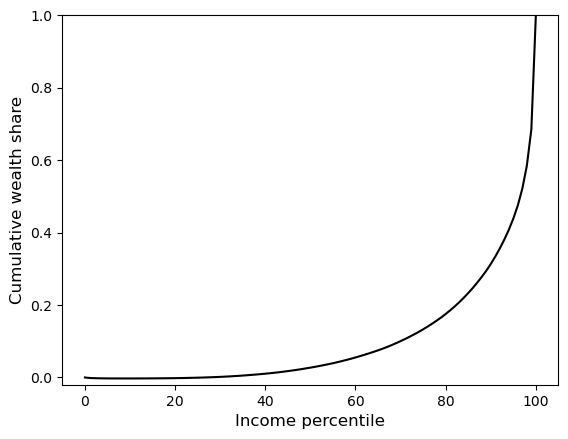

Estimate is center=1.0321840725453453, spread=0.013317421431722095
Lorenz distance is 2.0766810812874064
Average MPC for all consumers is 0.310
Average MPC in the top percentile of W/Y is 0.137
Average MPC in the top decile of W/Y is 0.138
Average MPC in the top quintile of W/Y is 0.139
Average MPC in the second quintile of W/Y is 0.152
Average MPC in the middle quintile of W/Y is 0.253
Average MPC in the fourth quintile of W/Y is 0.385
Average MPC in the bottom quintile of W/Y is 0.618
Average MPC in the top percentile of y is 0.290
Average MPC in the top decile of y is 0.282
Average MPC in the top quintile of y is 0.286
Average MPC in the second quintile of y is 0.316
Average MPC in the middle quintile of y is 0.320
Average MPC in the fourth quintile of y is 0.290
Average MPC in the bottom quintile of y is 0.335
Average MPC for the employed is 0.299
Average MPC for the unemployed is 0.449
Average MPC for the retired is nan
Of the population with the 1/3 highest MPCs...
53.112% are in

In [30]:
options = {
    "param_name": param_name,
    "dist_type": dist_type,
    "run_estimation": run_estimation,
    "run_sensitivity": run_sensitivity,
    "find_beta_vs_KY": find_beta_vs_KY,
    "do_tractable": do_tractable,
    "do_param_dist": do_param_dist,
    "do_lifecycle": do_lifecycle,
    "do_agg_shocks": do_agg_shocks,
    "do_liquid": do_liquid,
    "do_combo_estimation": True,
}


EstimationEconomy = estimate(options, parameters)

In [31]:
# Construct the Lorenz curves and plot them

pctiles = np.linspace(0.001, 0.999, 15)
SCF_Lorenz_points = get_lorenz_shares(
    SCF_wealth, weights=SCF_weights, percentiles=pctiles
)

sim_wealth = np.asarray(EstimationEconomy.reap_state["aLvl"]).flatten()
sim_wealth_2 = np.concatenate(EstimationEconomy.reap_state["aLvl"])
sim_Lorenz_points_2 = get_lorenz_shares(sim_wealth_2, percentiles=pctiles)
print(sim_wealth)
print(EstimationEconomy.reap_state["aLvl"])
print(np.concatenate(EstimationEconomy.reap_state["aLvl"]))



[ 0.31850291  0.69959626  0.99274182 ... 18.43368763  3.71957909
 13.81562698]
[array([0.31850291, 0.69959626, 0.99274182, ..., 0.55565906, 1.54530919,
       0.52127583]), array([0.51743713, 0.59350533, 1.94836304, ..., 1.46028887, 0.23415813,
       0.93269154]), array([0.60310624, 1.73655254, 2.34116497, ..., 1.45554329, 1.84393202,
       1.15153128]), array([2.40150655, 0.71505618, 1.34221479, ..., 3.62303962, 0.57071637,
       0.97502673]), array([19.75144906,  6.96048511,  5.66021597, ..., 10.49823315,
        6.7590939 ,  3.14463526]), array([51.17671659,  5.09530976,  2.82544902, ..., 26.7243511 ,
        7.64024858,  9.1726343 ]), array([  9.23372633,  26.74176477, 131.78275491, ...,  18.43368763,
         3.71957909,  13.81562698])]
[ 0.31850291  0.69959626  0.99274182 ... 18.43368763  3.71957909
 13.81562698]


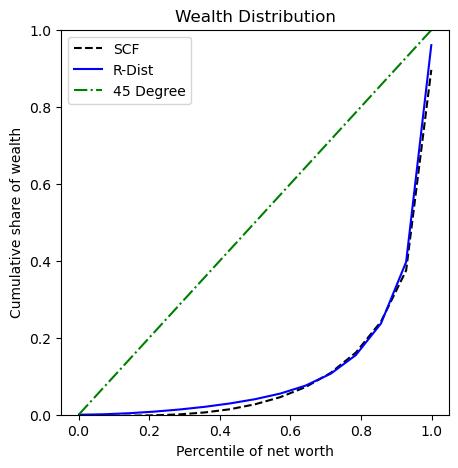

In [32]:
# Plot
plt.figure(figsize=(5, 5))
plt.title("Wealth Distribution")
plt.plot(pctiles, SCF_Lorenz_points, "--k", label="SCF")
plt.plot(pctiles, sim_Lorenz_points_2, "-b", label="R-Dist")
plt.plot(pctiles, pctiles, "g-.", label="45 Degree")
plt.xlabel("Percentile of net worth")
plt.ylabel("Cumulative share of wealth")
plt.legend(loc=2)
plt.ylim([0, 1])
plt.show("wealth_distribution_2")

## Life-cycle version of the model

We are interested in comparing the estimated distribution of the rate of return across households to measurements of its empirical counterpart. To be sure that the two objects of interest are comparable, we reestimate the life-cycle version of the model. It should be the case that a wider distribution of return is needed to match the empirical wealth targets, since wealth cannot grow without bounds under the assumption of a finite lifetime for households.

### $\Rfree$-point model

In [10]:
do_param_dist = False  
do_lifecycle = True  
do_agg_shocks = False  
do_liquid = False  
do_tractable = True  

Beginning an estimation with the specification name LCrratePointIndNetWorth...
1.0063522012578616
1.0063522012578616
1.0063522012578616
get_KY_ratio_difference tried center = 1.0063522012578616 and got -3.1340139385076844
1.1163522012578617
1.1163522012578617
1.1163522012578617
get_KY_ratio_difference tried center = 1.1163522012578617 and got 790467.7875949797
1.006352637379576
1.006352637379576
1.006352637379576
get_KY_ratio_difference tried center = 1.006352637379576 and got -3.133571899365565
1.0338470917051459
1.0338470917051459
1.0338470917051459
get_KY_ratio_difference tried center = 1.0338470917051459 and got 260.1773599676403
1.0070070412727383
1.0070070412727383
1.0070070412727383
get_KY_ratio_difference tried center = 1.0070070412727383 and got -2.4252169303243702
1.0092238228645751
1.0092238228645751
1.0092238228645751
get_KY_ratio_difference tried center = 1.0092238228645751 and got 0.7628581866547641
1.0081629382095356
1.0081629382095356
1.0081629382095356
get_KY_ratio_dif

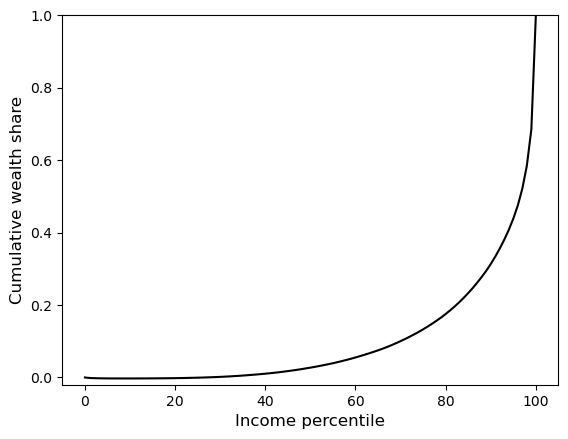

Estimate is center=1.0087704637147437, spread=0.0
Lorenz distance is 18.6894995573199
Average MPC for all consumers is 0.143
Average MPC in the top percentile of W/Y is 0.086
Average MPC in the top decile of W/Y is 0.095
Average MPC in the top quintile of W/Y is 0.094
Average MPC in the second quintile of W/Y is 0.082
Average MPC in the middle quintile of W/Y is 0.077
Average MPC in the fourth quintile of W/Y is 0.097
Average MPC in the bottom quintile of W/Y is 0.365
Average MPC in the top percentile of y is 0.094
Average MPC in the top decile of y is 0.106
Average MPC in the top quintile of y is 0.114
Average MPC in the second quintile of y is 0.134
Average MPC in the middle quintile of y is 0.142
Average MPC in the fourth quintile of y is 0.151
Average MPC in the bottom quintile of y is 0.175
Average MPC for the employed is 0.116
Average MPC for the unemployed is 0.153
Average MPC for the retired is 0.215
Of the population with the 1/3 highest MPCs...
47.623% are in the bottom wealt

In [11]:
options = {
    "param_name": param_name,
    "dist_type": dist_type,
    "run_estimation": run_estimation,
    "run_sensitivity": run_sensitivity,
    "find_beta_vs_KY": find_beta_vs_KY,
    "do_tractable": do_tractable,
    "do_param_dist": do_param_dist,
    "do_lifecycle": do_lifecycle,
    "do_agg_shocks": do_agg_shocks,
    "do_liquid": do_liquid,
    "do_combo_estimation": True,
}


EstimationEconomy = estimate(options, parameters)

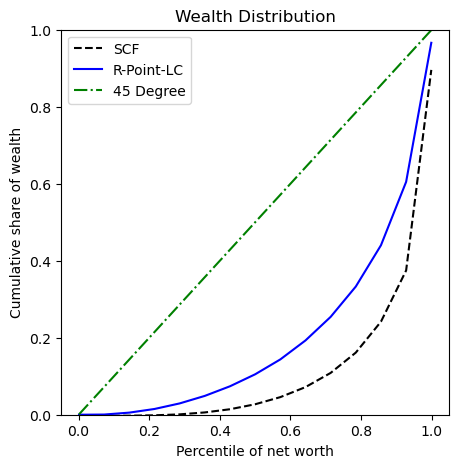

In [12]:
# Construct the Lorenz curves and plot them

pctiles = np.linspace(0.001, 0.999, 15)
SCF_Lorenz_points = get_lorenz_shares(
    SCF_wealth, weights=SCF_weights, percentiles=pctiles
)

sim_wealth = EstimationEconomy.reap_state["aLvl"][0]
sim_Lorenz_points = get_lorenz_shares(sim_wealth, percentiles=pctiles)

# Plot
plt.figure(figsize=(5, 5))
plt.title("Wealth Distribution")
plt.plot(pctiles, SCF_Lorenz_points, "--k", label="SCF")
plt.plot(pctiles, sim_Lorenz_points, "-b", label="R-Point-LC")
plt.plot(pctiles, pctiles, "g-.", label="45 Degree")
plt.xlabel("Percentile of net worth")
plt.ylabel("Cumulative share of wealth")
plt.legend(loc=2)
plt.ylim([0, 1])
plt.show("wealth_distribution_3")


### $\Rfree$-dist model

In [35]:
do_param_dist = True  
do_lifecycle = True  
do_agg_shocks = False  
do_liquid = False  
do_tractable = False  

Beginning an estimation with the specification name LCrrateDistIndNetWorth...
1.0254285714285714
1.0254285714285714
1.0254285714285714
1.0282857142857142
1.0282857142857142
1.0282857142857142
1.0311428571428571
1.0311428571428571
1.0311428571428571
1.034
1.034
1.034
1.036857142857143
1.036857142857143
1.036857142857143
1.0397142857142858
1.0397142857142858
1.0397142857142858
1.0425714285714287
1.0425714285714287
1.0425714285714287
get_KY_ratio_difference tried center = 1.034 and got 364.89367657798675
find_lorenz_distance_at_target_KY tried spread = 0.01 and got 6.219294301722323
1.0254285814285713
1.0254285814285713
1.0254285814285713
1.0282857242857142
1.0282857242857142
1.0282857242857142
1.031142867142857
1.031142867142857
1.031142867142857
1.03400001
1.03400001
1.03400001
1.0368571528571429
1.0368571528571429
1.0368571528571429
1.0397142957142858
1.0397142957142858
1.0397142957142858
1.0425714385714286
1.0425714385714286
1.0425714385714286
get_KY_ratio_difference tried center = 1.

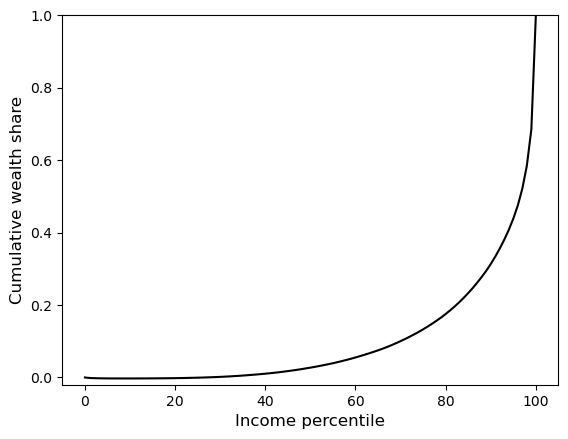

Estimate is center=1.0063522012578616, spread=0.010971744400395925
Lorenz distance is 9.354788923139294
Average MPC for all consumers is 0.213
Average MPC in the top percentile of W/Y is 0.090
Average MPC in the top decile of W/Y is 0.092
Average MPC in the top quintile of W/Y is 0.088
Average MPC in the second quintile of W/Y is 0.082
Average MPC in the middle quintile of W/Y is 0.101
Average MPC in the fourth quintile of W/Y is 0.194
Average MPC in the bottom quintile of W/Y is 0.601
Average MPC in the top percentile of y is 0.144
Average MPC in the top decile of y is 0.158
Average MPC in the top quintile of y is 0.167
Average MPC in the second quintile of y is 0.193
Average MPC in the middle quintile of y is 0.210
Average MPC in the fourth quintile of y is 0.229
Average MPC in the bottom quintile of y is 0.268
Average MPC for the employed is 0.175
Average MPC for the unemployed is 0.240
Average MPC for the retired is 0.312
Of the population with the 1/3 highest MPCs...
50.005% are i

In [36]:
options = {
    "param_name": param_name,
    "dist_type": dist_type,
    "run_estimation": run_estimation,
    "run_sensitivity": run_sensitivity,
    "find_beta_vs_KY": find_beta_vs_KY,
    "do_tractable": do_tractable,
    "do_param_dist": do_param_dist,
    "do_lifecycle": do_lifecycle,
    "do_agg_shocks": do_agg_shocks,
    "do_liquid": do_liquid,
    "do_combo_estimation": True,
}


EstimationEconomy = estimate(options, parameters)

(21,)
(14000,)


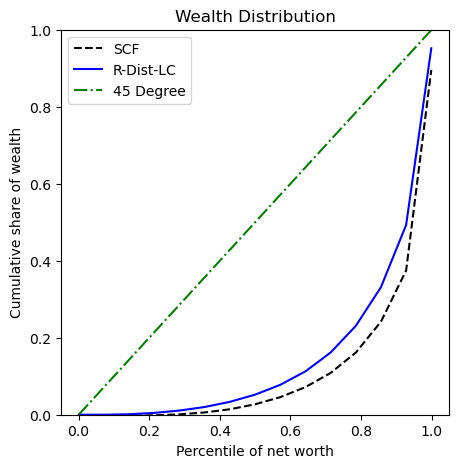

In [48]:
# Plot
pctiles = np.linspace(0.001, 0.999, 15)
SCF_Lorenz_points = get_lorenz_shares(
    SCF_wealth, weights=SCF_weights, percentiles=pctiles
)

sim_wealth_4 = np.concatenate(EstimationEconomy.reap_state["aLvl"])
sim_Lorenz_points_4 = get_lorenz_shares(sim_wealth_4, percentiles=pctiles)

plt.figure(figsize=(5, 5))
plt.title("Wealth Distribution")
plt.plot(pctiles, SCF_Lorenz_points, "--k", label="SCF")
plt.plot(pctiles, sim_Lorenz_points_4, "-b", label="R-Dist-LC")
plt.plot(pctiles, pctiles, "g-.", label="45 Degree")
plt.xlabel("Percentile of net worth")
plt.ylabel("Cumulative share of wealth")
plt.legend(loc=2)
plt.ylim([0, 1])
plt.show("wealth_distribution_4")

## Comparing the Estimation to Data on the Rate of Return

First, we present the graph of the estimated distribution of the rate of return across households which minimizes the Lorenz distance, given the empirical targets for wealth levels from the SCF data.

1.0455014939770673
1.0188666511136233


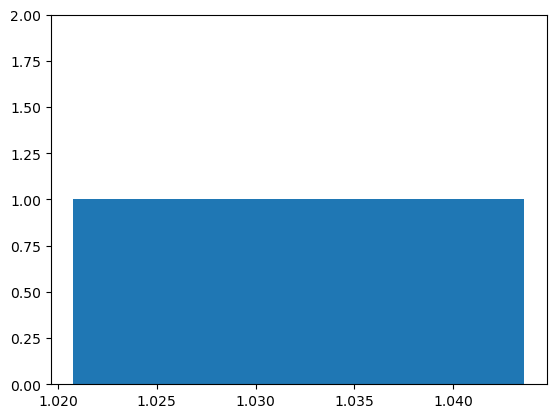

{'Mean': 1.0321840725453453,
 'Standard Deviation': 0.007688816848516381,
 'Skewness': 0,
 'Kurtosis': -1.2}

In [1]:
import re

from EstUniformDistAnalysis import EstUniformDist

PYUnif_RDist = EstUniformDist("/Users/dc/Library/CloudStorage/OneDrive-JohnsHopkins/research/GitHub-forks/econ-ark/DistributionOfWealthMPC/code/results/PYrrateDistIndNetWorthResults.txt")

print(PYUnif_RDist.top)
print(PYUnif_RDist.bottom)

PYUnif_RDist.graph()

PYUnif_RDist.show_moments()

1.0173239456582575
0.9953804568574657


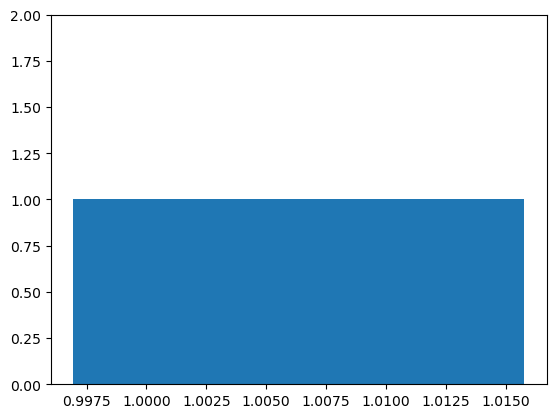

{'Mean': 1.0063522012578616,
 'Standard Deviation': 0.0063345395830483354,
 'Skewness': 0,
 'Kurtosis': -1.2}

In [3]:
LCUnif_RDist = EstUniformDist("/Users/dc/Library/CloudStorage/OneDrive-JohnsHopkins/research/GitHub-forks/econ-ark/DistributionOfWealthMPC/code/results/LCrrateDistIndNetWorthResults.txt")

print(LCUnif_RDist.top)
print(LCUnif_RDist.bottom)

LCUnif_RDist.graph()

LCUnif_RDist.show_moments()

### Graph of the empirical distribution of safe and risky returns from Fagereng et al. (2015)

![Image Description](/Users/dc/Library/CloudStorage/OneDrive-JohnsHopkins/research/GitHub-forks/econ-ark/DistributionOfWealthMPC/DistEmpReturnsFagereng.png)



NameError: name 'EstimationEconomy' is not defined